# 1. Carga de librerías a utilizar y setting del notebook

Utilizaremos las siguientes librerías:
1. **quantmod**: Para la descarga de datos de mercado
2. **ggplot2**: Para la visualización de datos
3. **data.table**: Para el manejo de datos

In [1]:
library(quantmod)
library(ggplot2)
library(data.table)
options(repr.plot.width=15, repr.plot.height=8)

Warning message:
"package 'quantmod' was built under R version 4.3.2"
Loading required package: xts

Warning message:
"package 'xts' was built under R version 4.3.2"
Loading required package: zoo

Warning message:
"package 'zoo' was built under R version 4.3.2"

Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Warning message:
"package 'TTR' was built under R version 4.3.2"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 




Attaching package: 'data.table'


The following objects are masked from 'package:xts':

    first, last




# 2. Carga y preparación de datos
### a. Obtenemos los datos históricos de Coca-Cola (KO) desde Yahoo Finance
quantmod nos permite traer datos de mercado desde Yahoo Finance. En este caso, traeremos los datos de Coca-Cola (KO) desde el 2 de mayo de 1962 hasta el presente.
Para esta demostración vamos a evitar cualquier tipo de representación financiera y vamos a representar en lineas temporales los precios de cierre de la acción.


In [2]:
KO <- getSymbols("KO",src="yahoo", from="1962-05-02", auto.assign=FALSE)

El resultado nos muestra la información que nos trae la librería quantmod

In [3]:
str(KO)

An xts object on 1962-05-02 / 2024-01-26 containing: 
  Data:    double [15540, 6]
  Columns: KO.Open, KO.High, KO.Low, KO.Close, KO.Volume ... with 1 more column
  Index:   Date [15540] (TZ: "UTC")
  xts Attributes:
    $ src    : chr "yahoo"
    $ updated: POSIXct[1:1], format: "2024-01-27 16:52:57"


### b. Preparación de dataframes para el análisis 
En este caso, vamos a utilizar el precio de cierre de la acción, convertimos las fechas en tipo "date" y nos quedamos con una ventana recortada de tiempo para el análisis y graficamos inicialmente los datos.

In [4]:
KO_closing <- as.data.frame(Cl(KO))
KO_closing$dt <- as.Date(row.names(KO_closing))
KO_closing <- data.table(KO_closing)
df_filtered <- KO_closing[ KO_closing$dt >= "1995-01-01" & KO_closing$dt <= "2005-12-31",]

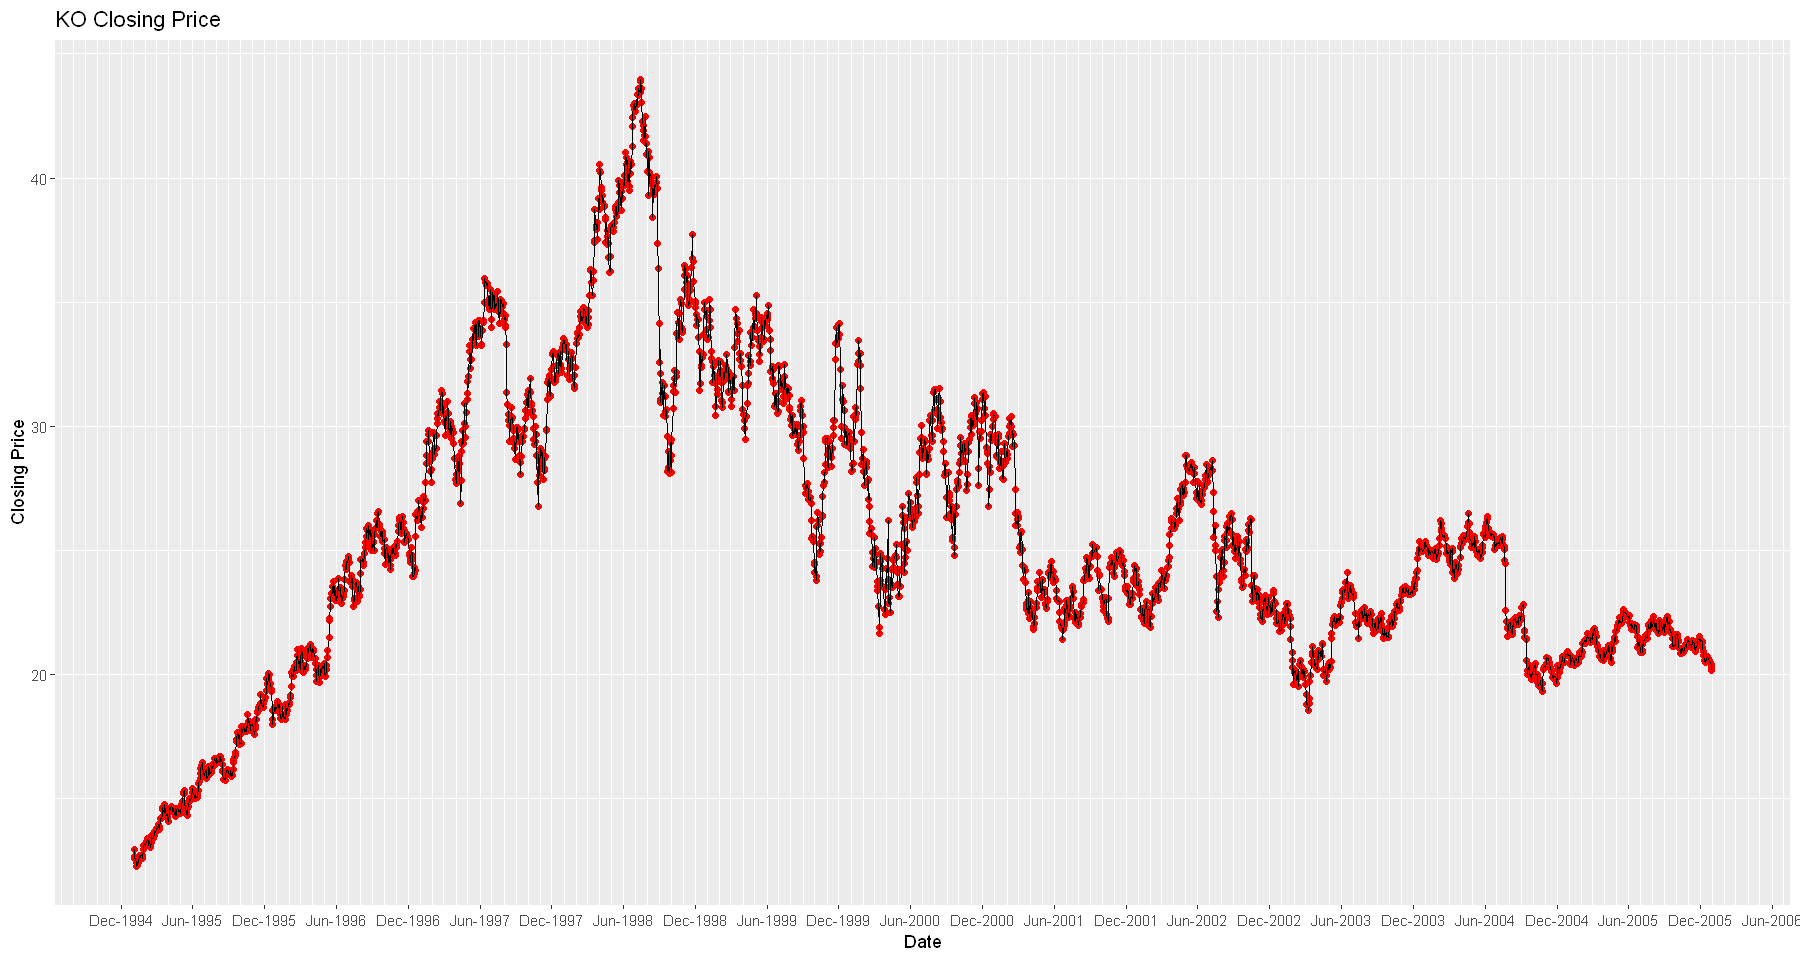

In [5]:
# plot the closing price
ggplot(df_filtered, aes(x=dt, y=KO.Close, group=1)) +
        geom_point(color='red') +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price")

# 3. Suavizado de las series de tiempo

### a. Suavizado con diferentes kernels y anchos de banda
Aplicamos el suavizado a las series de tiempo con diferentes valores de ancho de banda y para dos tipos de kernel: uniforme y gaussiano.
Los valores elegidos de ancho de banda para este caso son 10, 30, 50, 100 y 250

In [6]:
bandwidths = c(10, 30, 50, 100, 250)
for (bandwidth in bandwidths)
{
    df_smooth <- ksmooth(x= df_filtered$dt, y = df_filtered$KO.Close, kernel = "normal", bandwidth = bandwidth)
    df_smooth <- data.table(x=df_smooth$x, y=df_smooth$y)
    df_filtered[, paste0("normal_smooth_", bandwidth) := df_smooth$y]

    df_smooth <- ksmooth(x= df_filtered$dt, y = df_filtered$KO.Close, kernel = "box", bandwidth = bandwidth)
    df_smooth <- data.table(x=df_smooth$x, y=df_smooth$y)
    df_filtered[, paste0("box_smooth_", bandwidth) := df_smooth$y]
}

# 4. Gráficas de las series de tiempo suavizadas
### a. Suavizado con kernel gausiano de toda la serie de tiempo

In [7]:
col_plot <- paste0("normal_smooth_", bandwidths)
dlong <- melt(df_filtered[,mget(c("dt", "KO.Close", col_plot))], id.vars="dt")

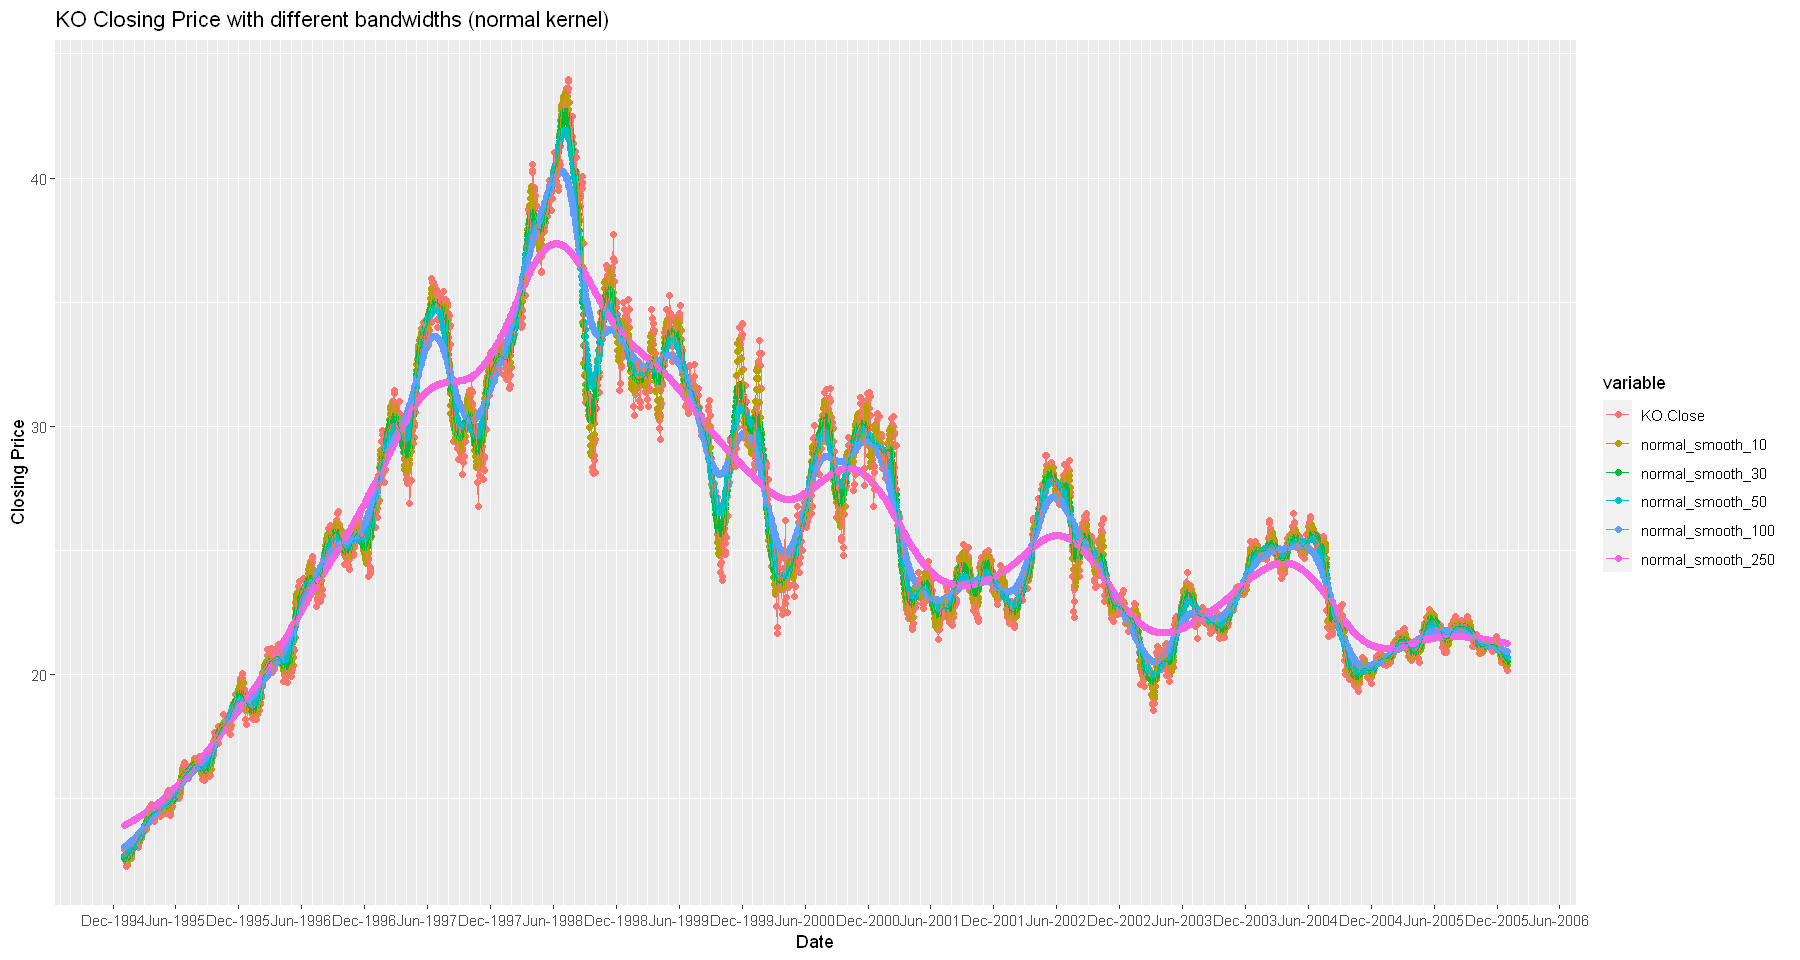

In [8]:
ggplot(dlong, aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with different bandwidths (normal kernel)")

### b. Suavizado con kernel gausiano de la serie de tiempo recortada a un año de datos (1998)

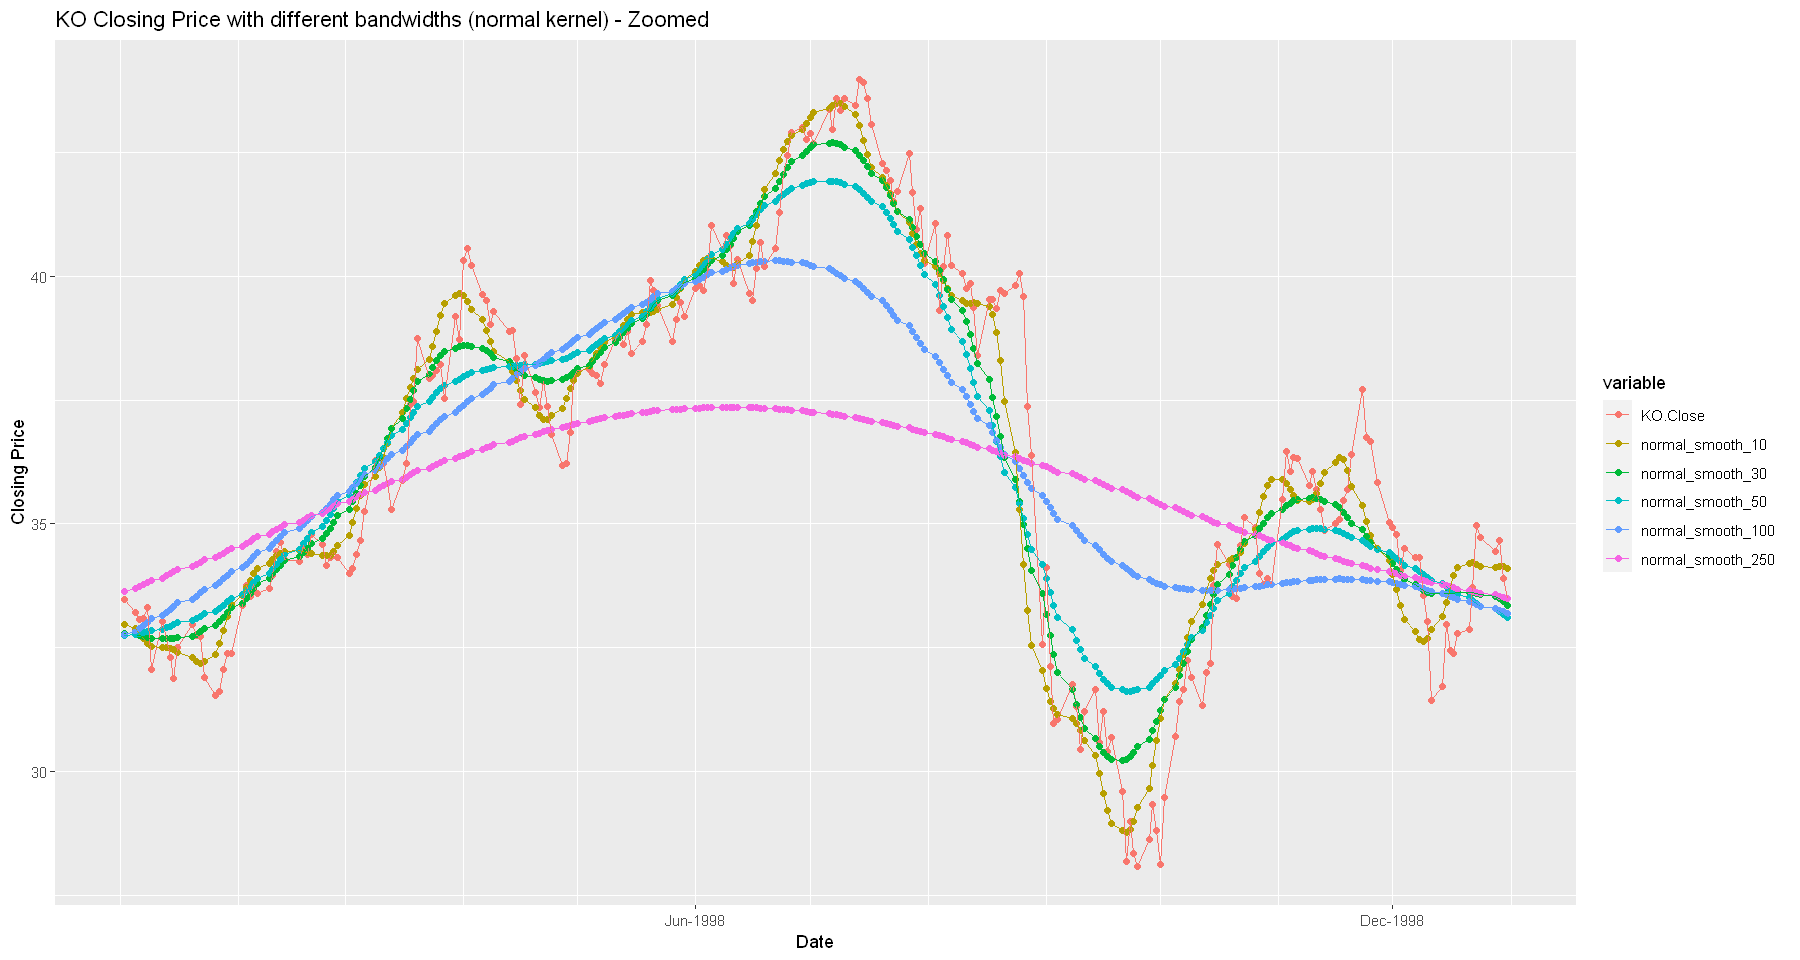

In [9]:
ggplot(dlong[dlong$dt >= '1998-01-01' & dlong$dt<'1999-01-01',], aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with different bandwidths (normal kernel) - Zoomed")

### c. Suavizado con kernel uniforme de toda la serie de tiempo

In [10]:
col_plot <- paste0("box_smooth_", bandwidths)
dlong <- melt(df_filtered[,mget(c("dt", "KO.Close", col_plot))], id.vars="dt")

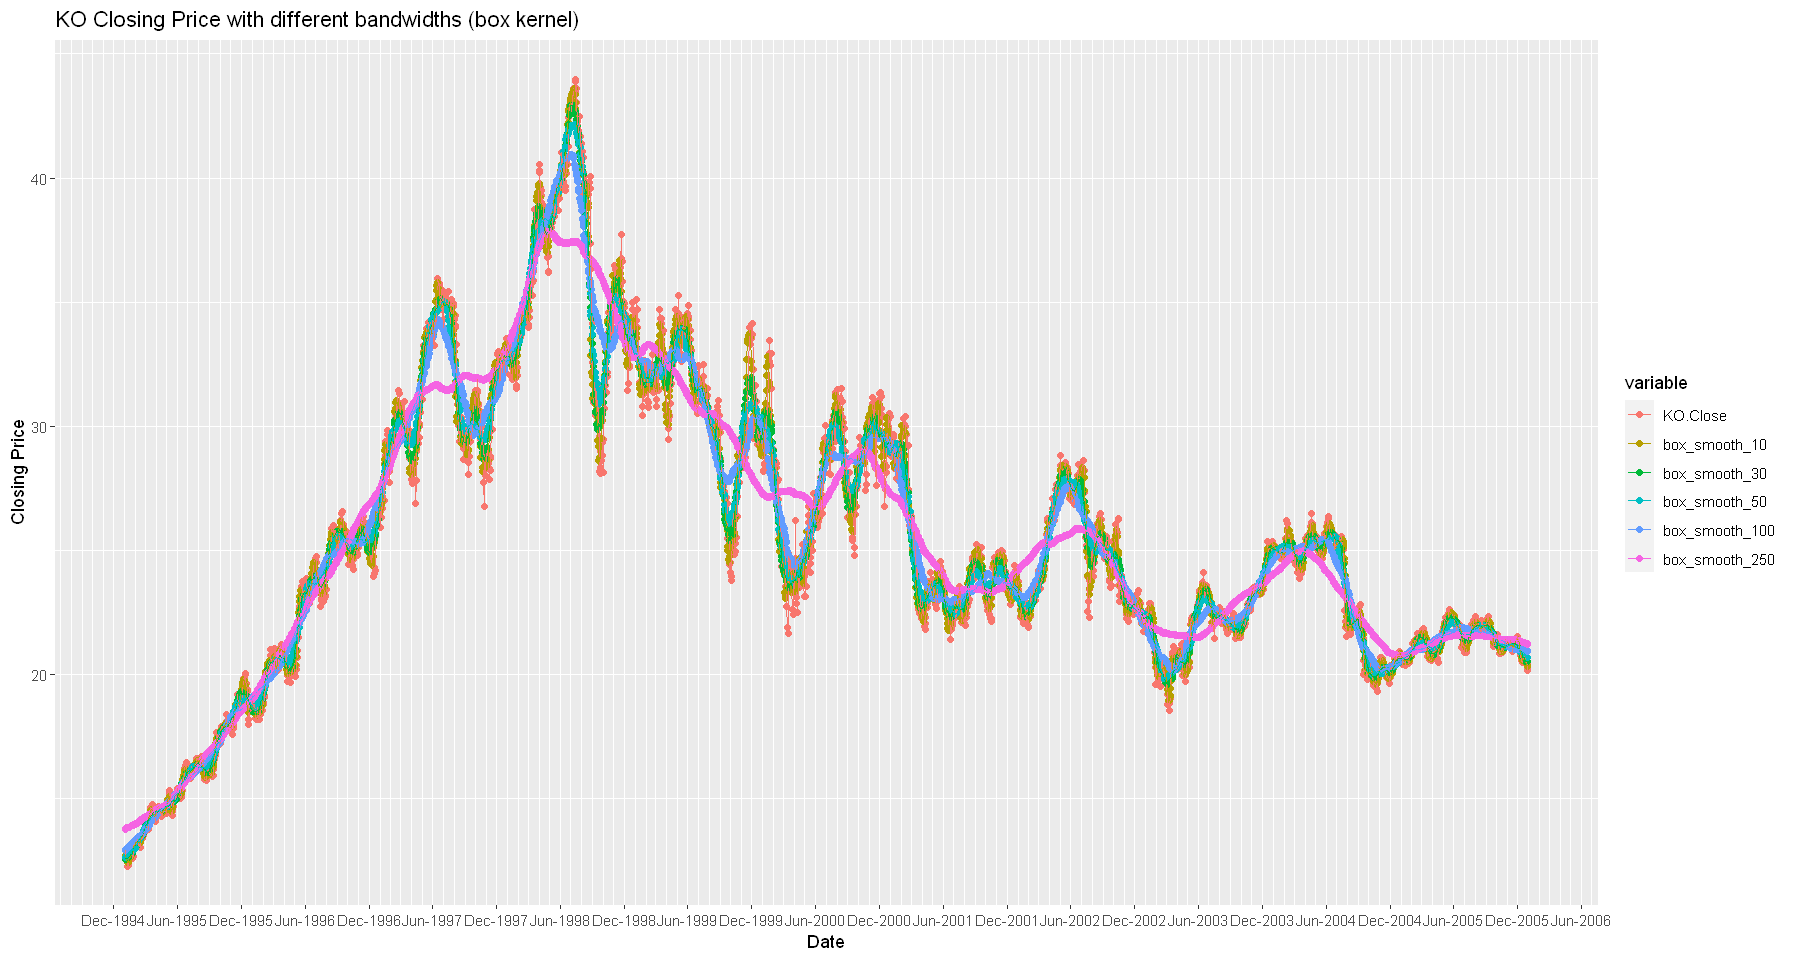

In [11]:
ggplot(dlong, aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with different bandwidths (box kernel)")

### d. Suavizado con kernel uniforme de la serie de tiempo recortada a un año de datos (1998)

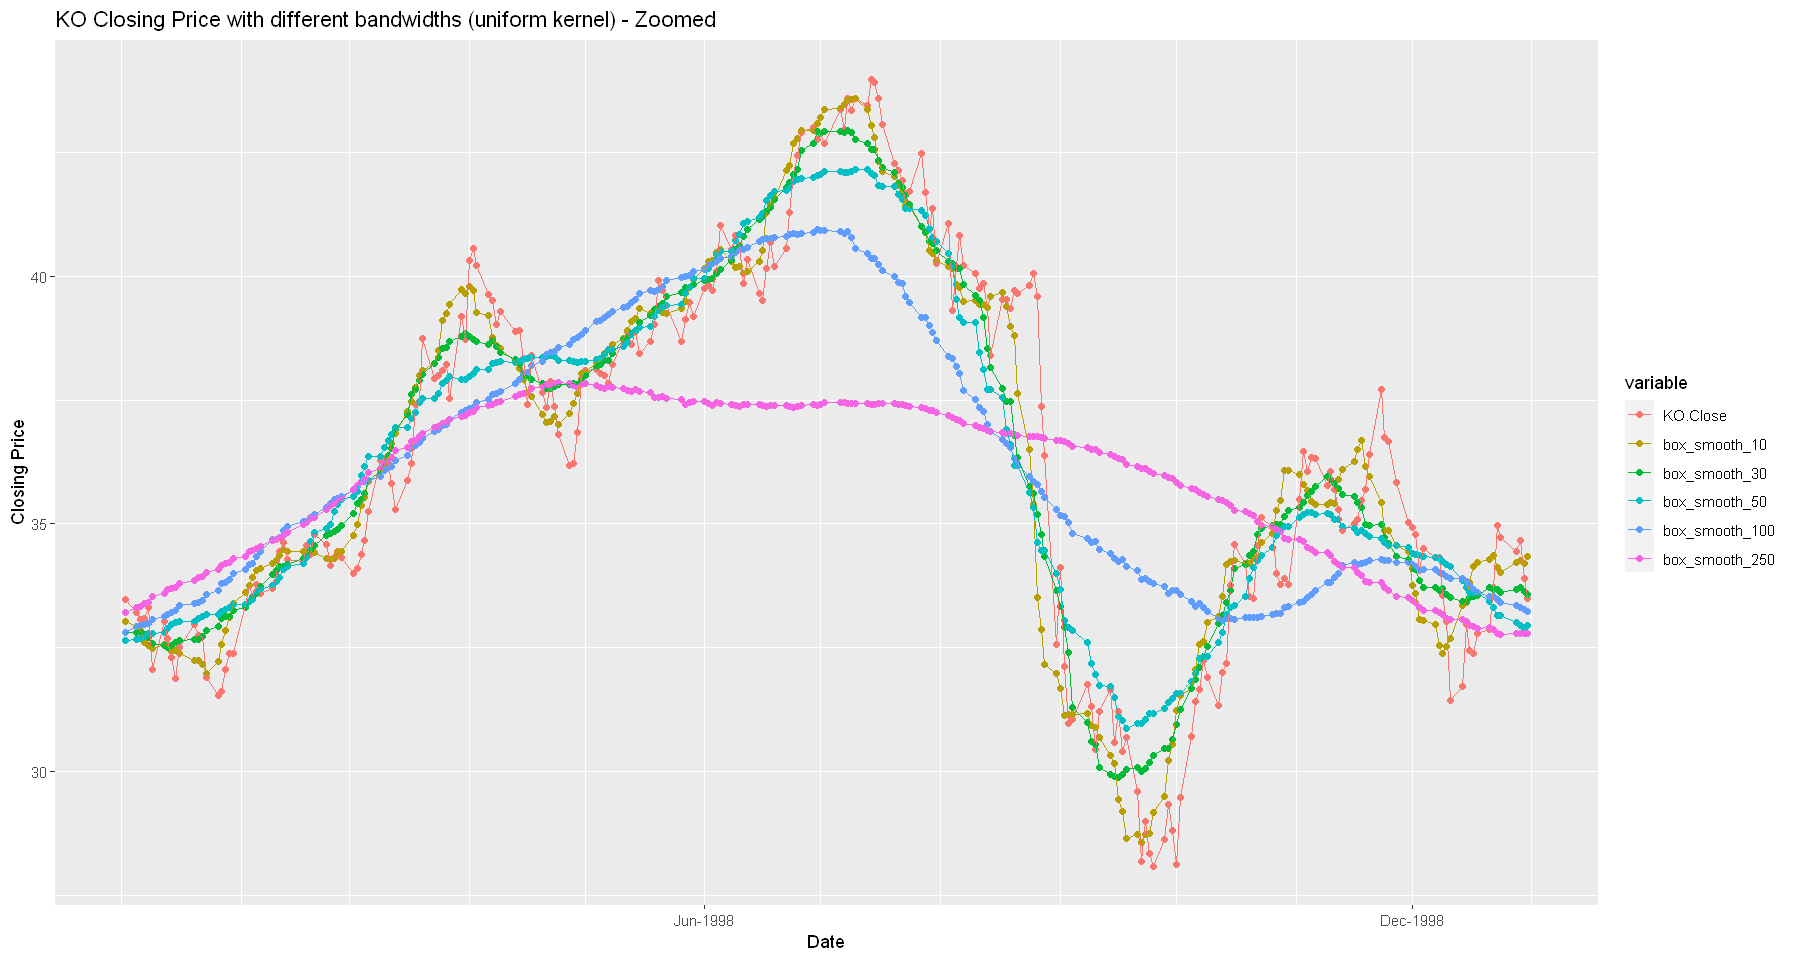

In [12]:
ggplot(dlong[dlong$dt >= '1998-01-01' & dlong$dt<'1999-01-01',], aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with different bandwidths (uniform kernel) - Zoomed")

### e. Comparación a un mismo ancho de banda de los diferentes kernels sobre todos los datos

In [13]:
bw <- 100
col_plot <- c("normal_smooth_100", "box_smooth_100")
dlong <- melt(df_filtered[,mget(c("dt", "KO.Close", col_plot))], id.vars="dt")

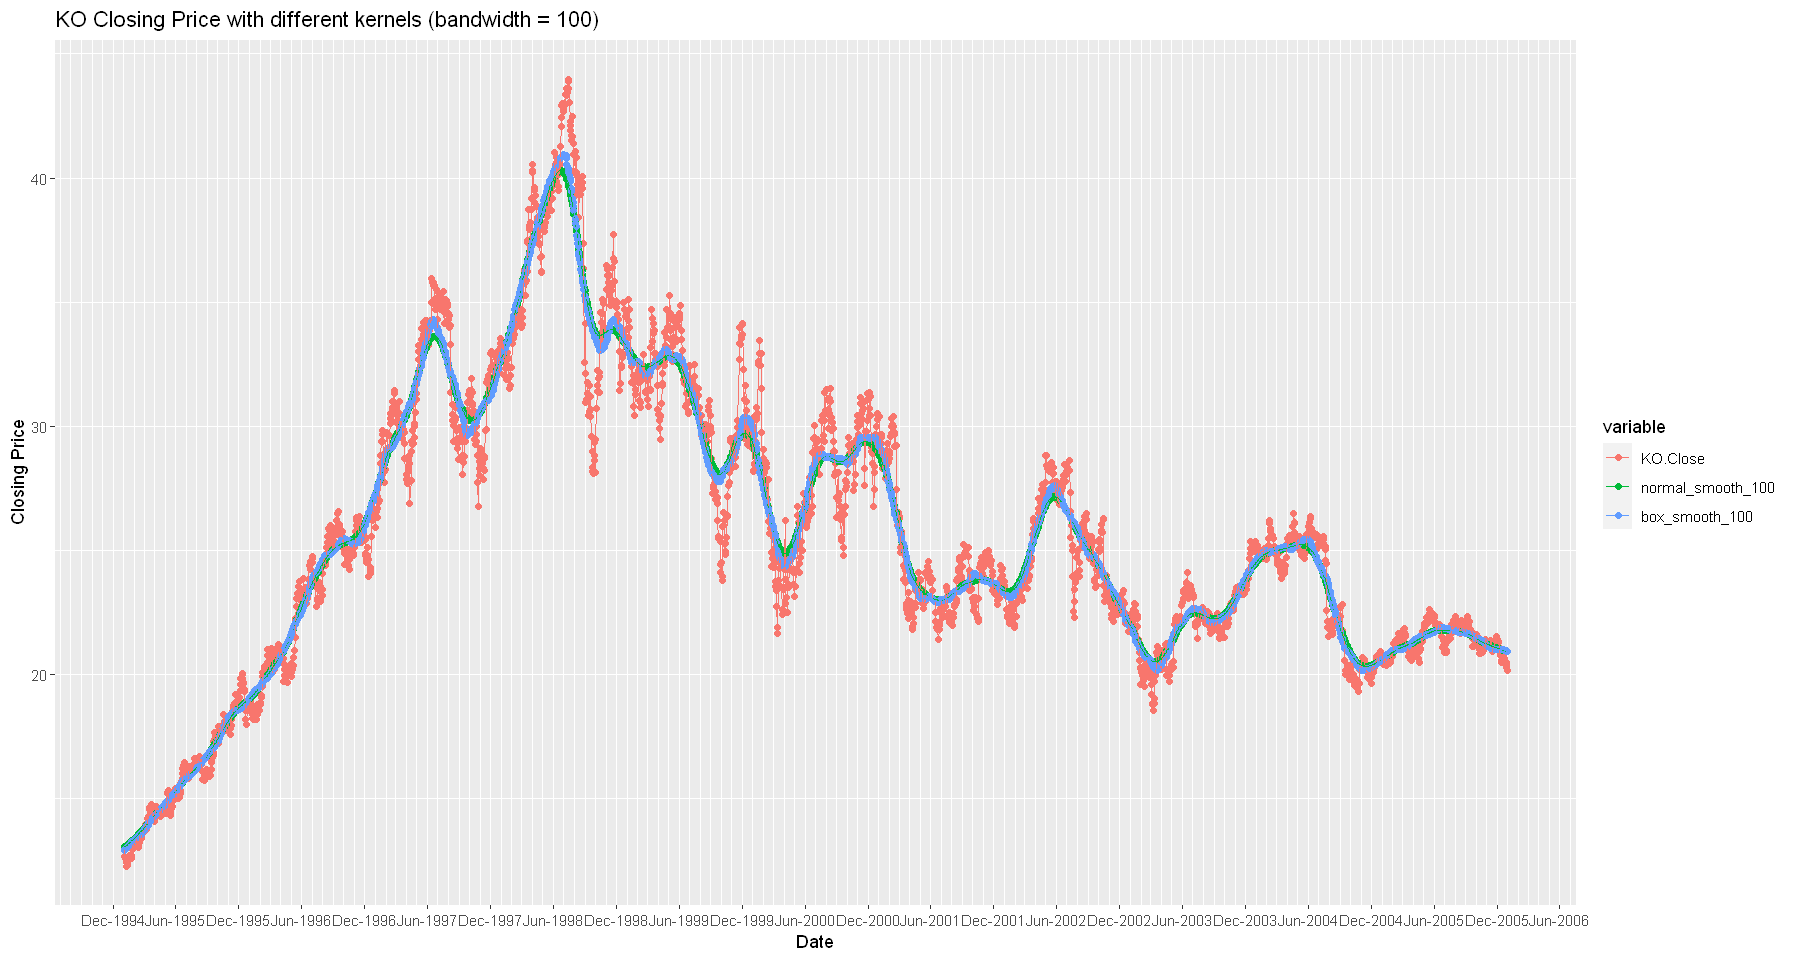

In [14]:
ggplot(dlong, aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with different kernels (bandwidth = 100)")

### f. Comparación a un mismo ancho de banda de los diferentes kernels sobre los datos recortados a un año (1998)

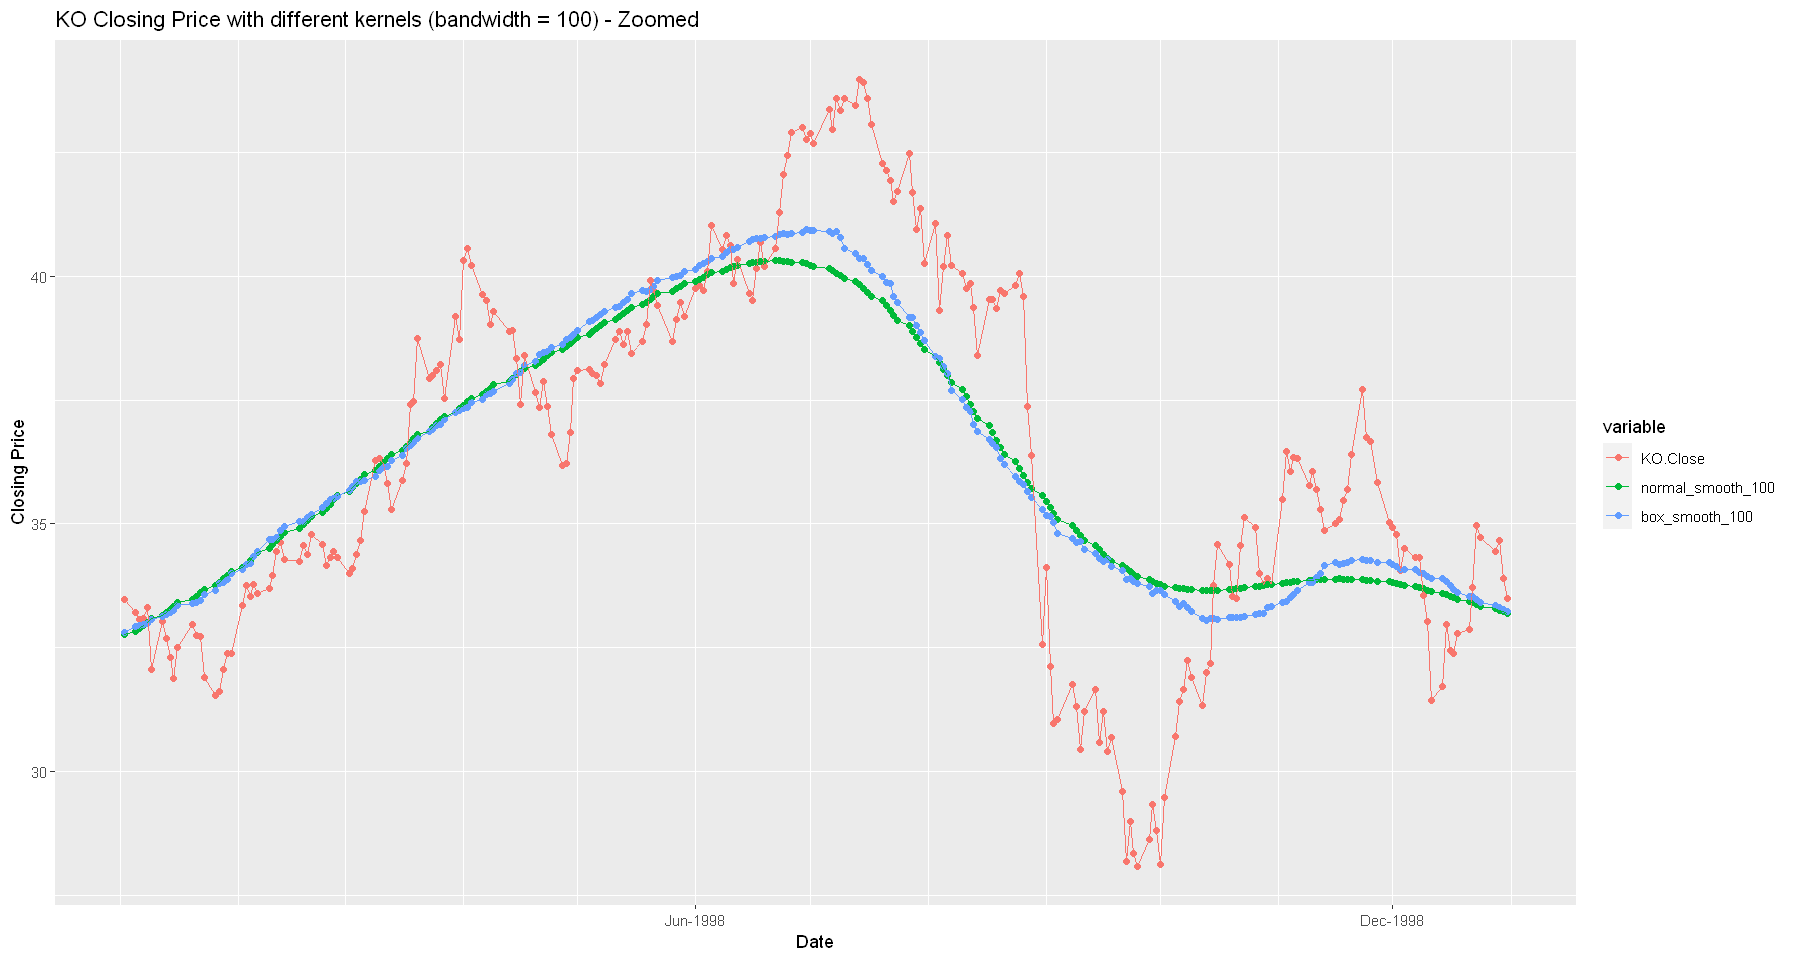

In [15]:
ggplot(dlong[dlong$dt >= '1998-01-01' & dlong$dt<'1999-01-01',], aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with different kernels (bandwidth = 100) - Zoomed")

# 5. Efecto del ancho de banda en el suavizado
El ancho de banda está directamente relacionado con la cantidad de puntos de la serie de tiempo que se utilizan para el suavizado. A mayor ancho de banda, mayor cantidad de puntos se utilizan para el suavizado y por lo tanto, mayor suavizado de la serie de tiempo. En este caso cada punto de datos representa un día de mercado, por lo que un ancho de banda de 10 representa un suavizado de 10 días, un ancho de banda de 30 representa un suavizado de 30 días, y así sucesivamente.
Al tener típicamente una ventana de mercado de 5 días semanales, un ancho de banda de 5 representa una semana, un ancho de banda de 10 representa dos y asi en adelante, hasta llegar el total de días de mercado en un año (aproximadamente 250 días).

### a. Suavizado con diferentes kernels y anchos de banda acoplados a la ventana de mercado

In [16]:
bandwidths = c(5, 10, 20, 40, 60, 250)
for (bandwidth in bandwidths)
{
    df_smooth <- ksmooth(x= df_filtered$dt, y = df_filtered$KO.Close, kernel = "normal", bandwidth = bandwidth)
    df_smooth <- data.table(x=df_smooth$x, y=df_smooth$y)
    df_filtered[, paste0("normal_smooth_", bandwidth) := df_smooth$y]

    df_smooth <- ksmooth(x= df_filtered$dt, y = df_filtered$KO.Close, kernel = "box", bandwidth = bandwidth)
    df_smooth <- data.table(x=df_smooth$x, y=df_smooth$y)
    df_filtered[, paste0("box_smooth_", bandwidth) := df_smooth$y]
}

### b. Suavizado con kernel gausiano de la serie de tiempo completa

In [17]:
col_plot <- paste0("normal_smooth_", bandwidths)
dlong <- melt(df_filtered[,mget(c("dt", "KO.Close", col_plot))], id.vars="dt")

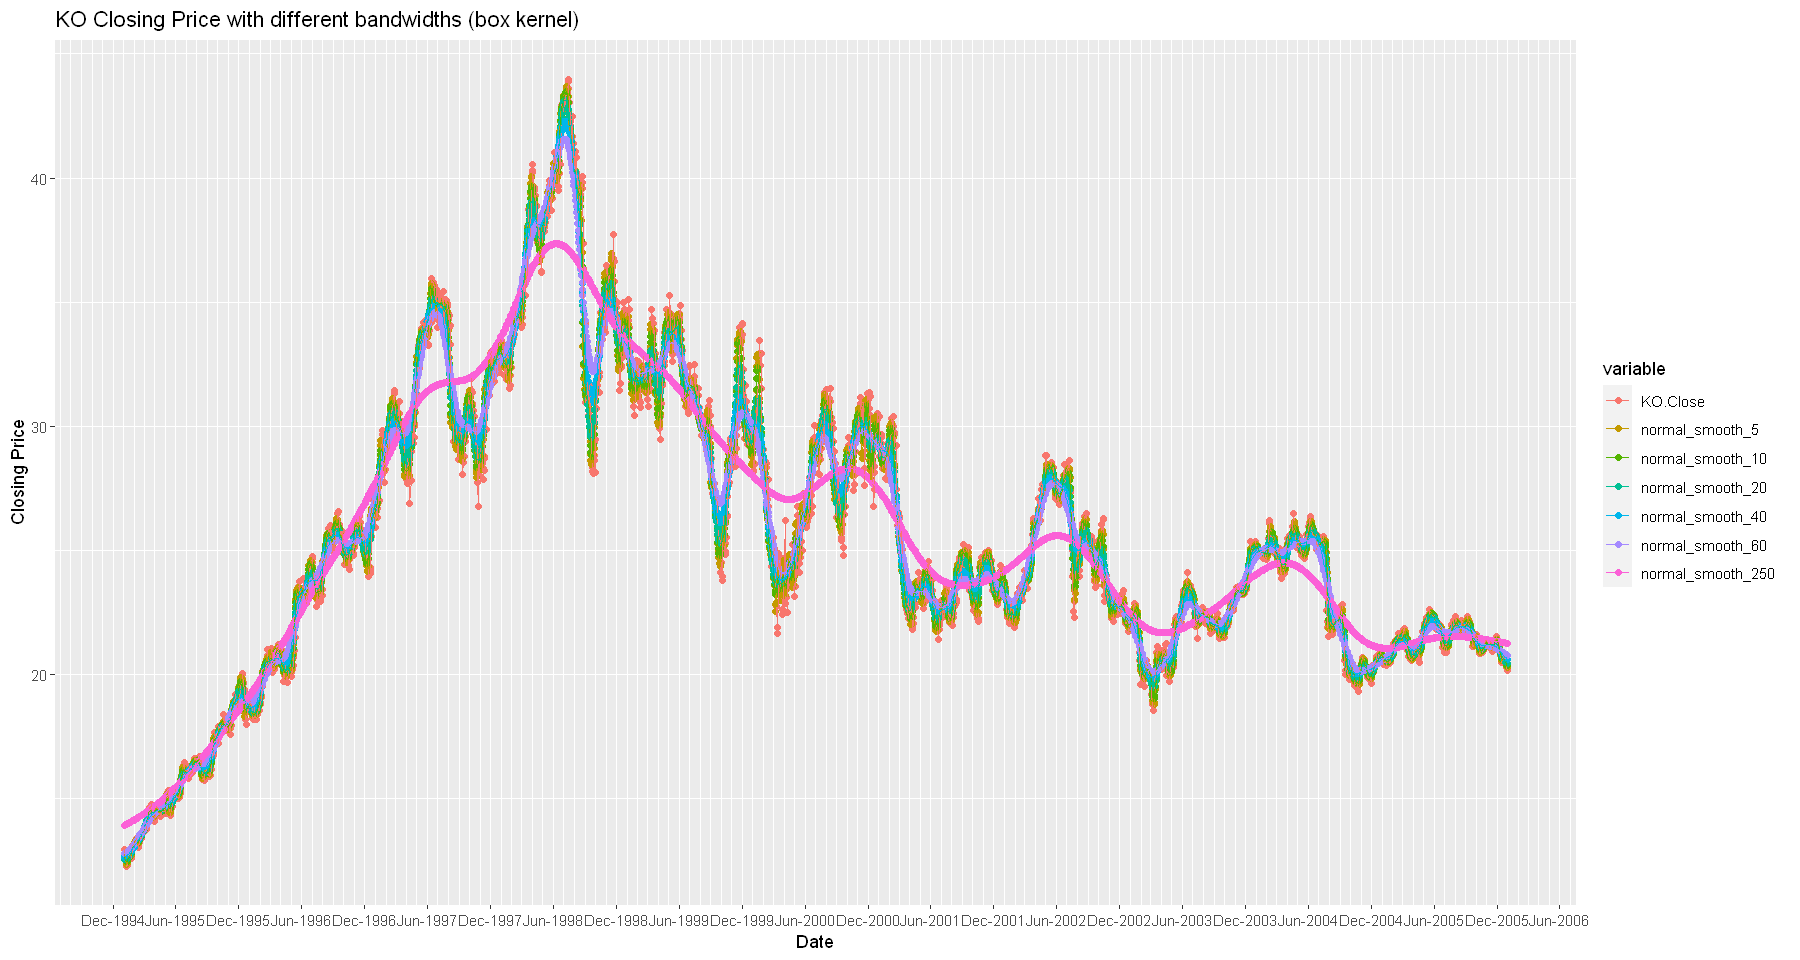

In [18]:
ggplot(dlong, aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "6 months", date_minor_breaks = "1 month", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with different bandwidths (box kernel)")

### c. Suavizado con kernel gausiano de la serie de tiempo recortada a un año de datos (1998)

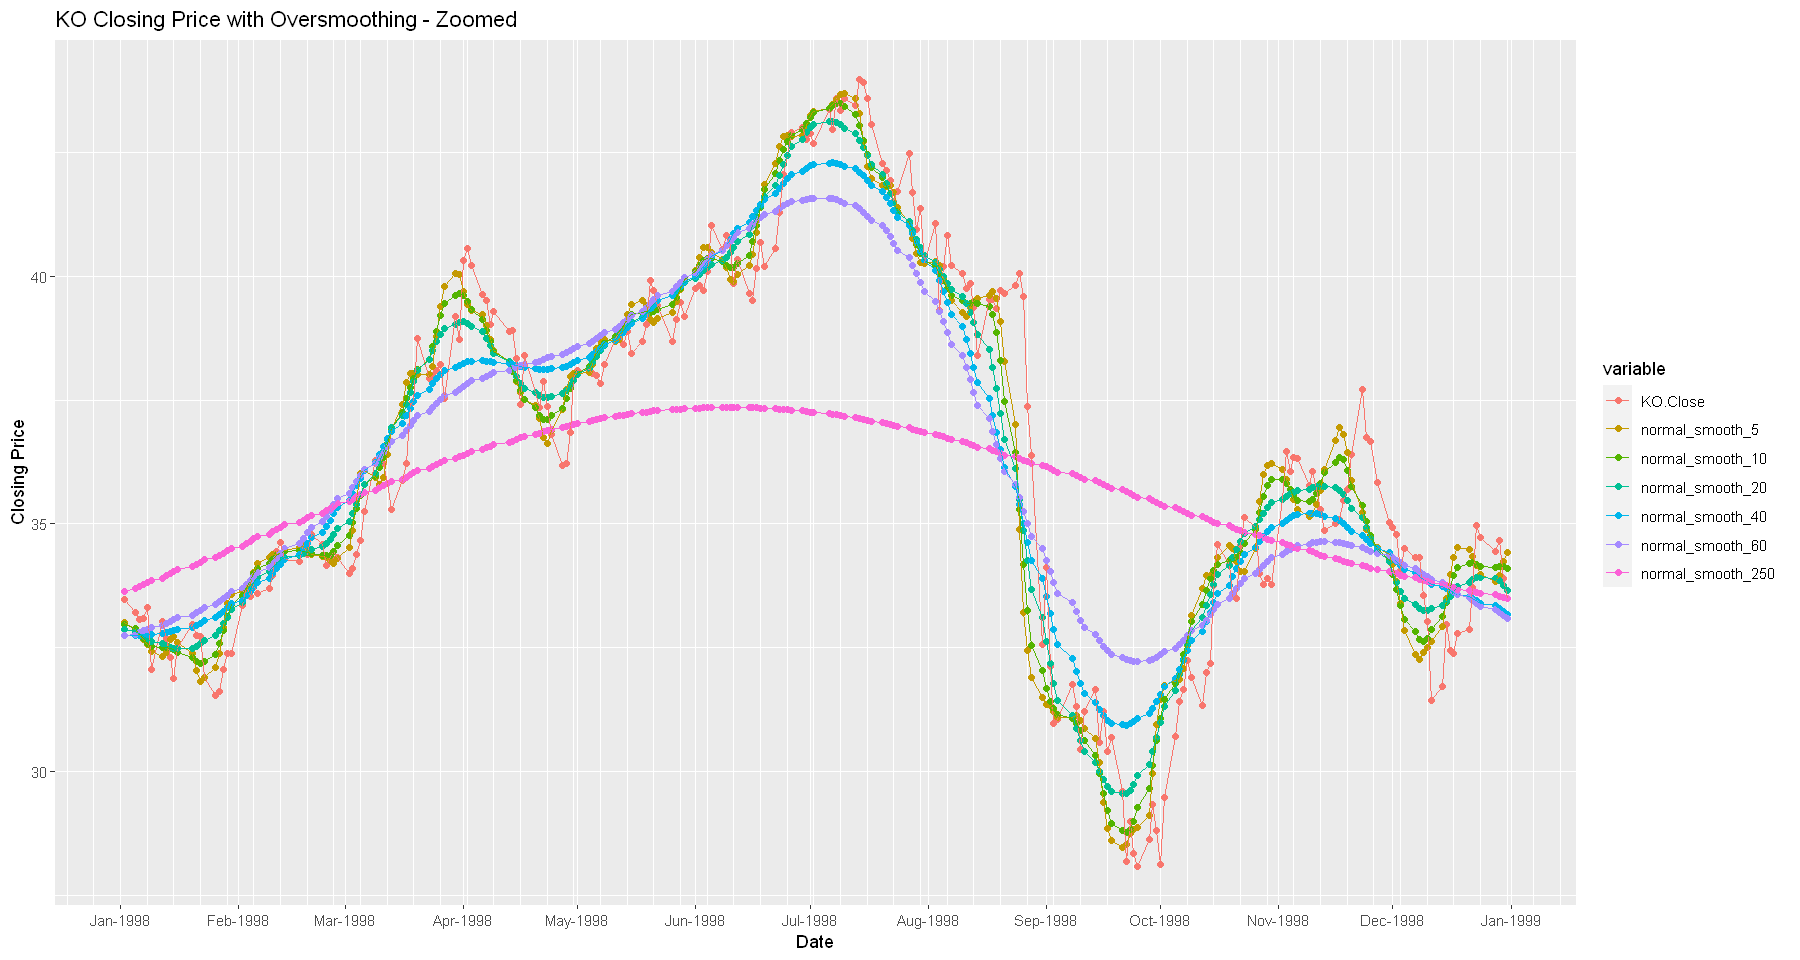

In [19]:
ggplot(dlong[dlong$dt >= '1998-01-01' & dlong$dt<'1999-01-01',], aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "1 months", date_minor_breaks = "7 days", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with Oversmoothing - Zoomed")

# 6. Limitaciones y posibles inconvenientes
Al existir un parámetro de ajuste, la elección del ancho de banda puede ser un problema y no tiene una definición única pues no sólo depende del kernel sino de la serie de tiempo en sí y de lo que realmente se quiere observar en ella. 
Por ejemplo, si se quiere observar el comportamiento de la serie de tiempo en un periodo de tiempo corto, un ancho de banda pequeño puede ser más adecuado, mientras que si se quiere observar el comportamiento de la serie de tiempo en un periodo de tiempo largo, un ancho de banda grande puede ser más adecuado.

Presentaremos dos ejemplos de elección de ancho de banda que son evidentemente problemáticos, en este caso nos limitaremos a la visualización de un año de datos (1998).

### a. Ancho de banda muy grande (oversmoothing)
En este caso tomamos un ancho de banda de 250 días. Como se puede observar, el suavizado es demasiado grande y no se puede observar ningún tipo de comportamiento de la serie de tiempo recortada, no es demasiada la información si queremos conseguir algún patrón de comportamiento viendo un año de datos, eso es evidente tomando en cuenta que dicho ancho de banda utiliza todo el año para suavizar

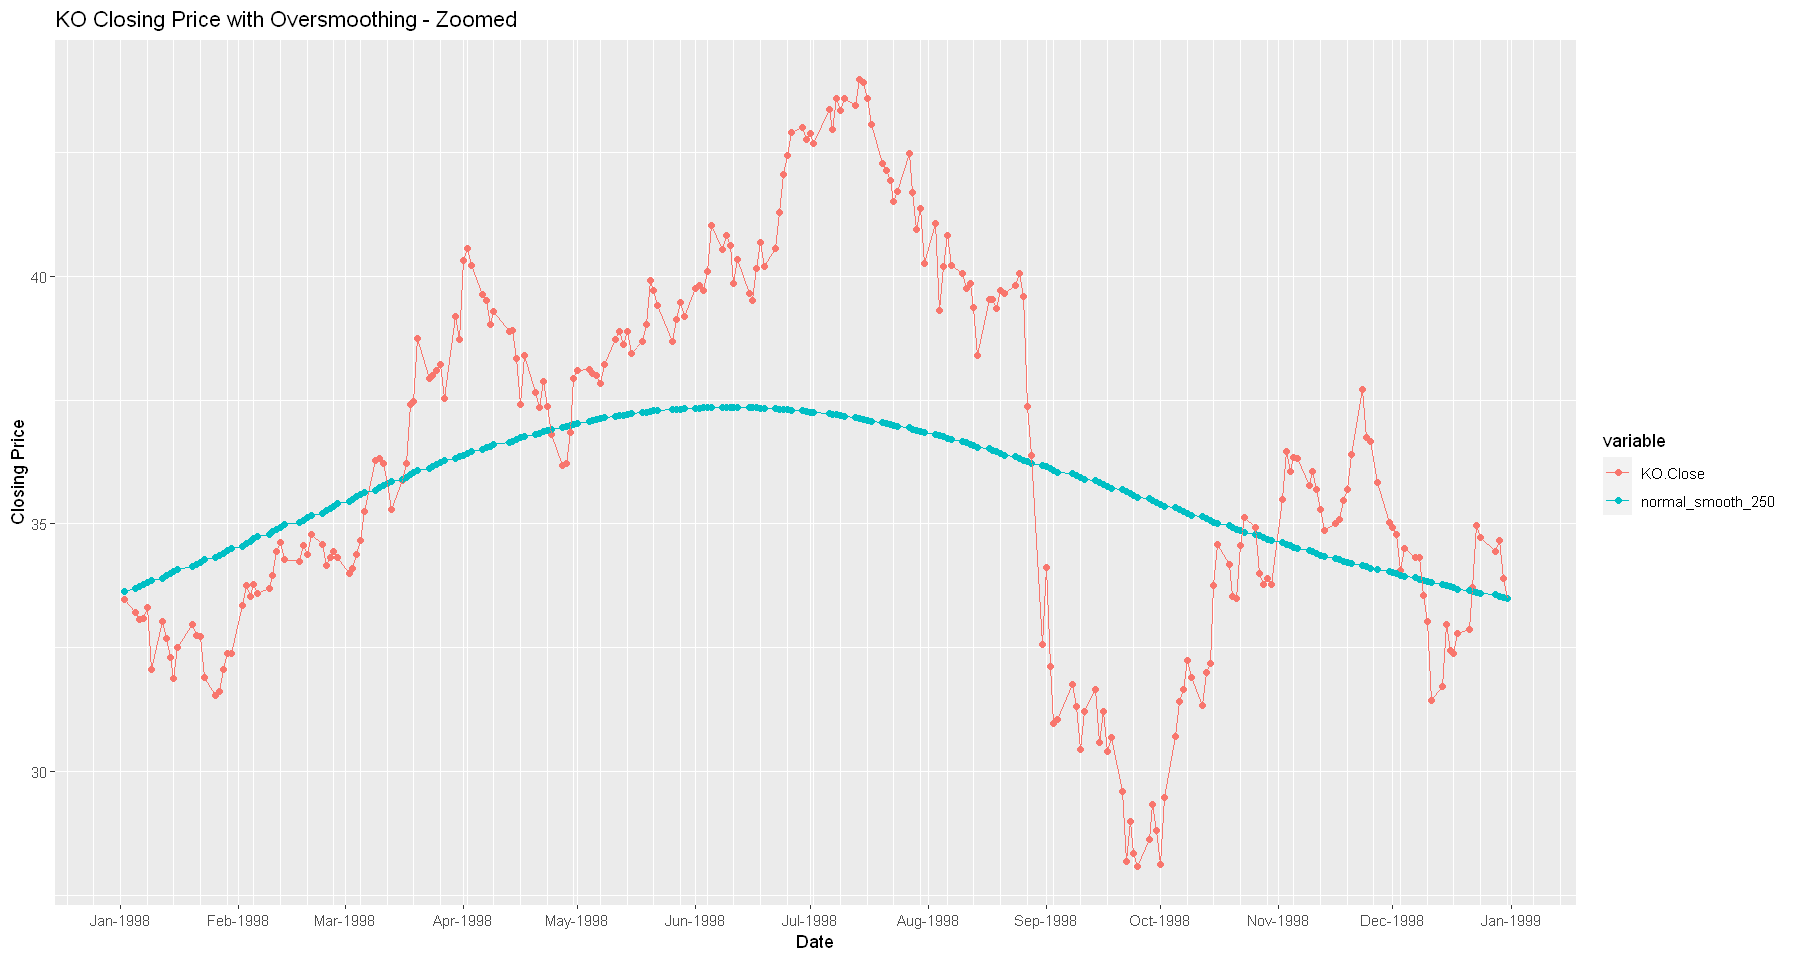

In [20]:
dlong <- melt(df_filtered[,mget(c("dt", "KO.Close", "normal_smooth_250"))], id.vars="dt")
ggplot(dlong[dlong$dt >= '1998-01-01' & dlong$dt<'1999-01-01',], aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "1 months", date_minor_breaks = "7 days", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with Oversmoothing - Zoomed")

### b. Ancho de banda muy pequeño (undersmoothing)
En este caso, utilizaremos un ancho de banda de 0.5 días. Como se puede observar, el suavizado es demasiado pequeño y no se puede observar ningún tipo de comportamiento de la serie de tiempo recortada, no es demasiada la información si queremos conseguir algún patrón de comportamiento viendo un año de datos, la serie temporal se vuelve muy ruidosa y ya no representa para nada a la serie original, eso es evidente tomando en cuenta que dicho ancho de banda utiliza sólo medio día (menor a cada punto de datos) para suavizar.

El caso de undersmoothing muestra que en lugar de suavizar, puede introducir más ruido. 

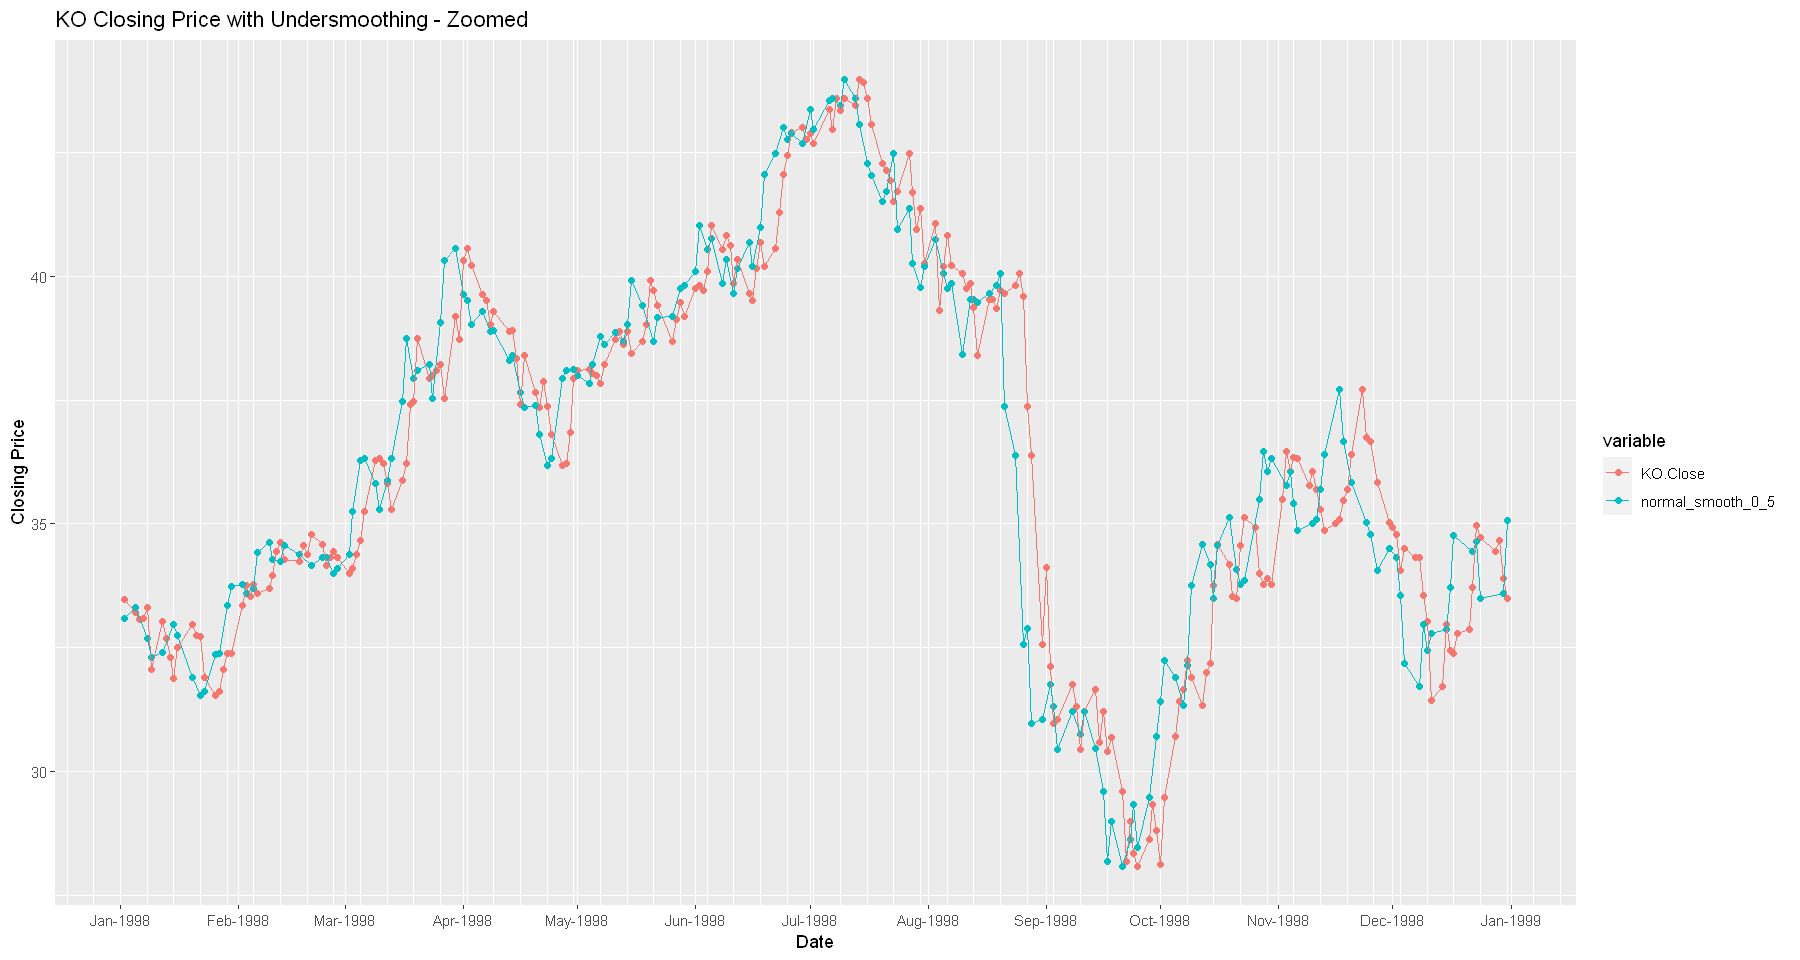

In [21]:
df_smooth <- ksmooth(x= df_filtered$dt, y = df_filtered$KO.Close, kernel = "normal", bandwidth = 0.5)
df_smooth <- data.table(x=df_smooth$x, y=df_smooth$y)
df_filtered[, paste0("normal_smooth_0_5") := df_smooth$y]
dlong <- melt(df_filtered[,mget(c("dt", "KO.Close", "normal_smooth_0_5"))], id.vars="dt")
dlong <- dlong[!is.na(dlong$value),]
ggplot(dlong[dlong$dt >= '1998-01-01' & dlong$dt<'1999-01-01',], aes(x=dt, y=value, group=variable, color=variable)) +
        geom_point() +
        geom_line() +
        xlab("Date") +
        scale_x_date(breaks = "1 months", date_minor_breaks = "7 days", date_labels = "%b-%Y") +
        ylab("Closing Price") +
        ggtitle("KO Closing Price with Undersmoothing - Zoomed")

# 7. Selección inteligente de parámetros
Ya pudimos ver que la selección de parámetros es un tema importante en el suavizado de series de tiempo. En este ejercicio, vamos a ver cómo podemos seleccionar los parámetros de suavizado de forma inteligente.
La idea es utilizar el principio de cross-validation en el cual intentaremos encontrar el parámetro de suavizado que minimiza el error de predicción. 
Para ello vamos a definir una función de error que puede ser el MSE para que se pueda penalizar más a los errores más grandes y con cualquier signo.
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Luego vamos a definir una función que nos permita calcular el error de predicción para un ancho de banda dado y una serie de tiempo dada. Esta función nos va a devolver el error de predicción para cada punto de la serie de tiempo y obtendremos el error de predicción total sumando los errores de predicción de cada punto.

Esto lo vamos a hacer para cada ancho de banda y luego vamos a graficar el error de predicción para cada ancho de banda. El ancho de banda que minimice el error de predicción será el ancho de banda que mejor se ajuste a la serie de tiempo particular que estamos observando.

In [34]:
mse_smooth <- function(x_input, y_input, bandwidth)
{
    df_smooth <- ksmooth(x = x_input, y = y_input, kernel = "normal", bandwidth = bandwidth)
    df_smooth <- data.table(x=df_smooth$x, y=df_smooth$y)
    df_smooth[, y_base := y_input]
    df_smooth[, error := (y - y_base)^2]
    return(sum(df_smooth$error)/nrow(df_smooth))
}

De la manera más simple, podemos calcular para un set de anchos de banda para el dataset que estuvimos probando

In [35]:
bandwidths = c(5, 10, 20, 40, 60, 250)
bandwidth_range = seq(0, 300, 5)
min_error <- 1e10
min_bandwidth <- 0
for (bandwidth in bandwidth_range)
{
    val <- mse_smooth(df_filtered$dt, df_filtered$KO.Close, bandwidth)
    if (!is.na(val) && val < min_error)
    {
        min_error <- val
        min_bandwidth <- bandwidth
    }
    if (bandwidth %in% bandwidths)
        print(paste0("bandwidth = ", bandwidth, " mse = ", val))
}
print(paste0("min bandwidth = ", min_bandwidth, " min mse = ", min_error))

[1] "bandwidth = 5 mse = 0.485460042226443"
[1] "bandwidth = 10 mse = 0.400674102472695"
[1] "bandwidth = 20 mse = 0.39738691219865"
[1] "bandwidth = 40 mse = 0.582886571658427"
[1] "bandwidth = 60 mse = 0.82639470486588"
[1] "bandwidth = 250 mse = 3.00664864094867"
[1] "min bandwidth = 15 min mse = 0.380665102111191"


Este resultado da que el ancho de banda que minimiza el error de predicción es el de 20 días. Sin embargo, esto realmente no sería la manera más general de hacerlo, ya que el ancho de banda que minimiza el error de predicción para estas fechas podría no ser el ancho de banda que minimiza el error de predicción para otras fechas. Por lo tanto, lo que vamos a hacer es calcular el error de predicción para cada ancho de banda para diferentes rangos de fechas más reducidos. 

In [36]:
calc_and_plot_best_bw <- function(df, start_date, end_date) {
    df_dates <- df[ df$dt >= start_date & df$dt <= end_date,]
    bandwidths = c(5, 10, 20, 40, 60, 250)
    bandwidth_range = seq(0, 300, 5)
    min_error <- 1e10
    min_bandwidth <- 0
    for (bandwidth in bandwidth_range)
    {
        val <- mse_smooth(df_dates$dt, df_dates$KO.Close, bandwidth)
        if (!is.na(val) && val < min_error)
        {
            min_error <- val
            min_bandwidth <- bandwidth
        }
        if (bandwidth %in% bandwidths)
            print(paste0("bandwidth = ", bandwidth, " mse = ", val))
    }
    print(paste0("min bandwidth = ", min_bandwidth, " min mse = ", min_error))
    title <- paste0("KO Closing Price with optimal BW = ", min_bandwidth, " (", start_date, " - ", end_date, ")")

    df_smooth <- ksmooth(x= df_dates$dt, y = df_dates$KO.Close, kernel = "normal", bandwidth = min_bandwidth)
    df_smooth <- data.table(x=df_smooth$x, y=df_smooth$y)
    df_dates[, paste0("smooth") := df_smooth$y]
    dlong <- melt(df_dates[,mget(c("dt", "KO.Close", "smooth"))], id.vars="dt")
    dlong <- dlong[!is.na(dlong$value),]
    plot <- ggplot(dlong, aes(x=dt, y=value, group=variable, color=variable)) +
            geom_point() +
            geom_line() +
            xlab("Date") +
            scale_x_date(breaks = "1 months", date_minor_breaks = "7 days", date_labels = "%b-%Y") +
            ylab("Closing Price") +
            ggtitle(title)
    ggsave(paste0("KO_closing_", start_date, "_", current_date, "_bw", min_bandwidth, ".png"), plot=plot, width=15, height=8)
    return(plot)
}


[1] "bandwidth = 5 mse = 0.0112041493302499"
[1] "bandwidth = 10 mse = 0.0217972090984538"
[1] "bandwidth = 20 mse = 0.0472326458297367"
[1] "bandwidth = 40 mse = 0.0826472782853092"
[1] "bandwidth = 60 mse = 0.11313863248295"
[1] "bandwidth = 250 mse = 0.676275836620639"
[1] "min bandwidth = 5 min mse = 0.0112041493302499"
[1] "bandwidth = 5 mse = 0.0313611974134674"
[1] "bandwidth = 10 mse = 0.0460427086475622"
[1] "bandwidth = 20 mse = 0.087079366527547"
[1] "bandwidth = 40 mse = 0.177028029950459"
[1] "bandwidth = 60 mse = 0.25559901836096"
[1] "bandwidth = 250 mse = 0.656510608568523"
[1] "min bandwidth = 5 min mse = 0.0313611974134674"
[1] "bandwidth = 5 mse = 0.0570929670516864"
[1] "bandwidth = 10 mse = 0.0925104992083921"
[1] "bandwidth = 20 mse = 0.165030116131874"
[1] "bandwidth = 40 mse = 0.336467728545443"
[1] "bandwidth = 60 mse = 0.54520067962231"
[1] "bandwidth = 250 mse = 1.92889509335241"
[1] "min bandwidth = 5 min mse = 0.0570929670516864"


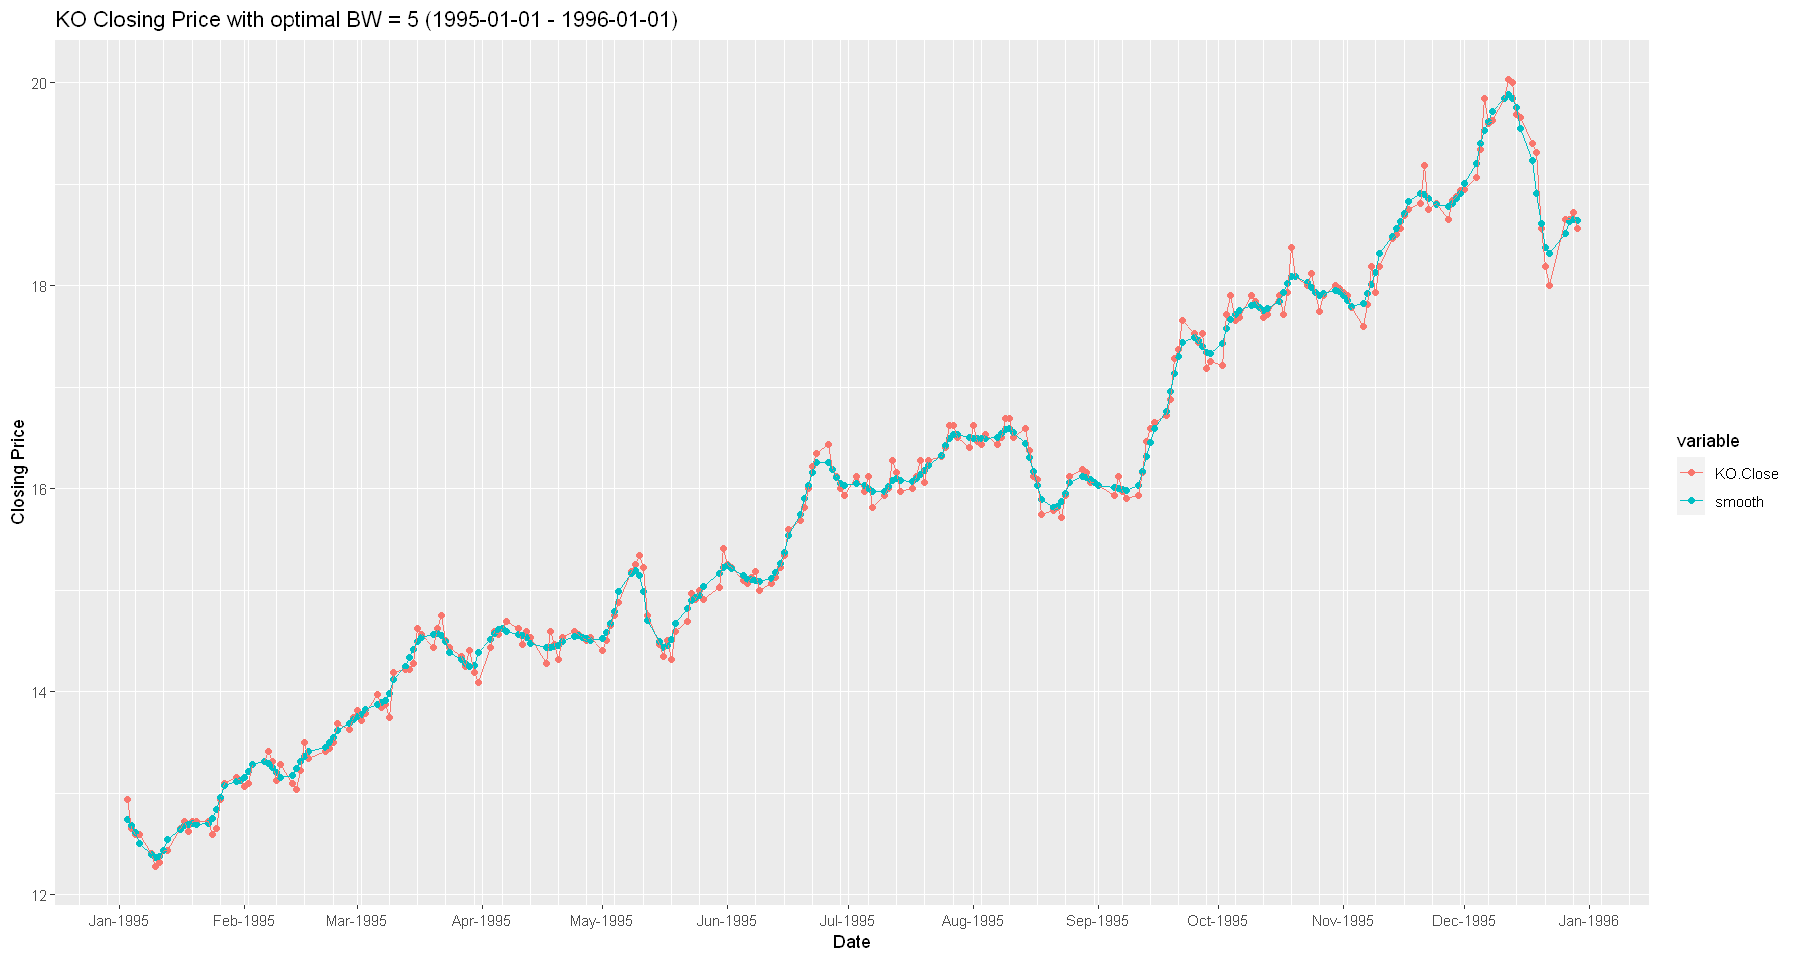

[1] "bandwidth = 5 mse = 0.100907912739587"
[1] "bandwidth = 10 mse = 0.148736913094656"
[1] "bandwidth = 20 mse = 0.269177187320889"
[1] "bandwidth = 40 mse = 0.556342496573945"
[1] "bandwidth = 60 mse = 0.939918283615156"
[1] "bandwidth = 250 mse = 4.07646212861168"
[1] "min bandwidth = 5 min mse = 0.100907912739587"


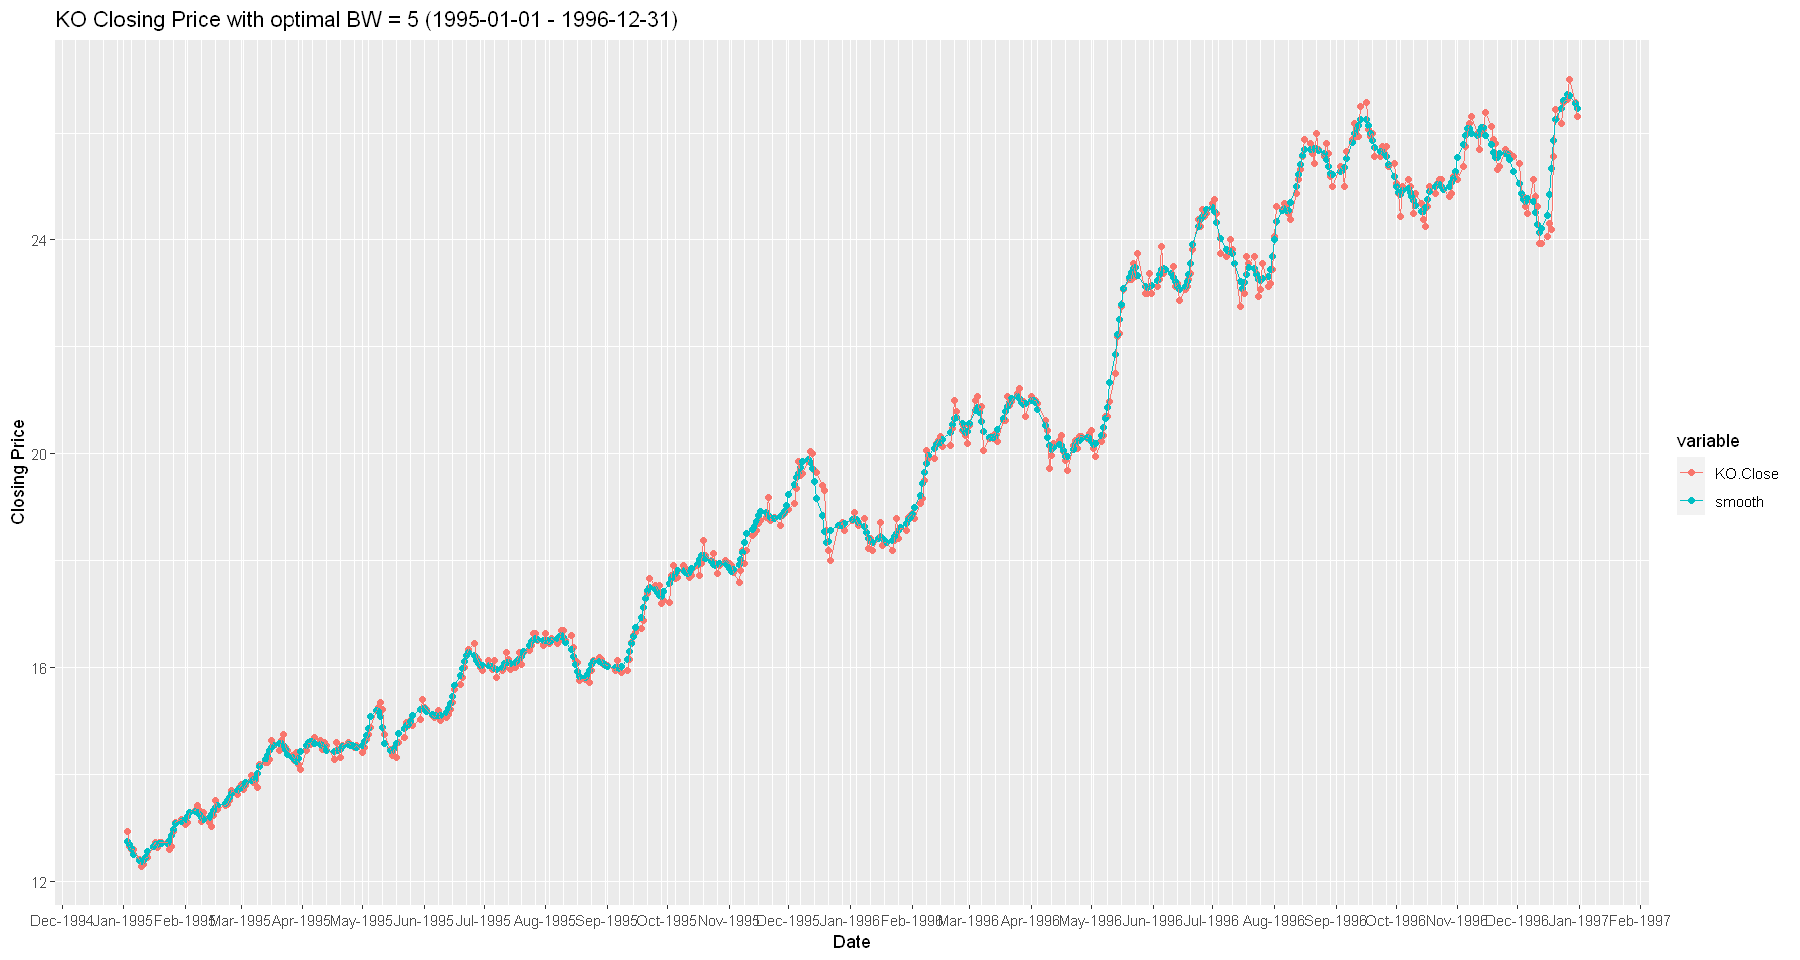

[1] "bandwidth = 5 mse = 0.139497709903427"
[1] "bandwidth = 10 mse = 0.186595176735029"
[1] "bandwidth = 20 mse = 0.323393051151209"
[1] "bandwidth = 40 mse = 0.65508306229373"
[1] "bandwidth = 60 mse = 1.04466968780223"
[1] "bandwidth = 250 mse = 3.9921353028083"
[1] "min bandwidth = 5 min mse = 0.139497709903427"


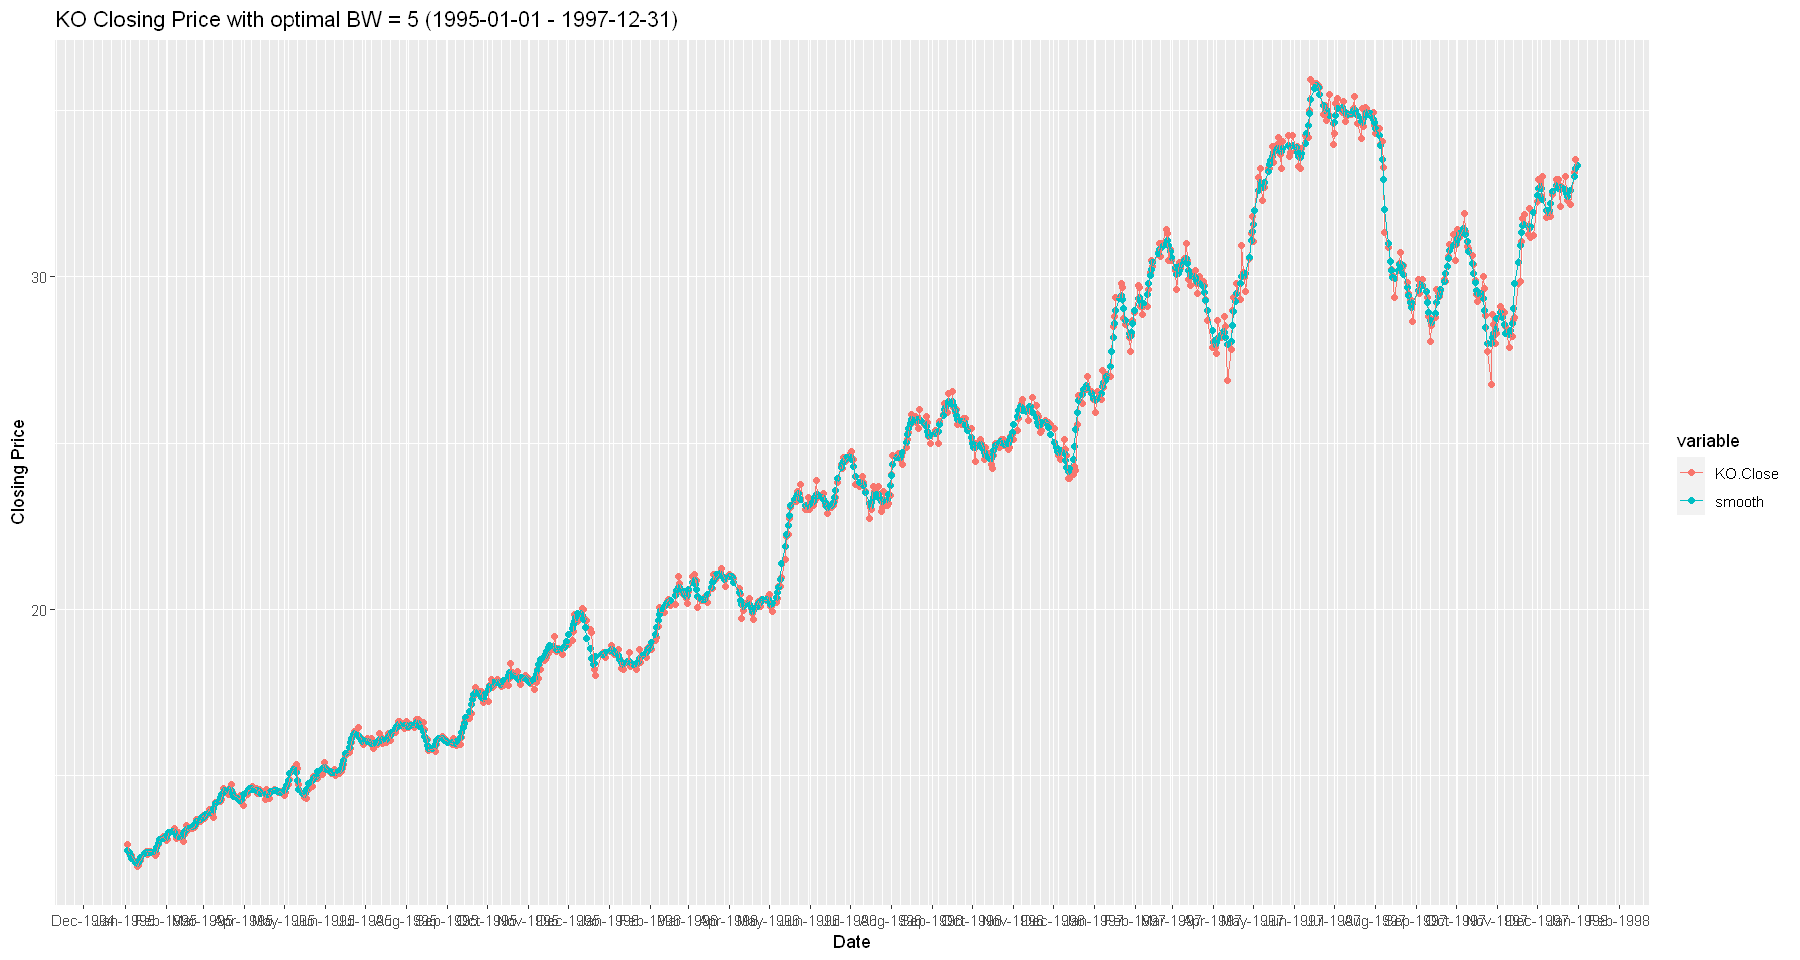

[1] "bandwidth = 5 mse = 0.156126797297238"
[1] "bandwidth = 10 mse = 0.217275166417778"
[1] "bandwidth = 20 mse = 0.378960512334657"
[1] "bandwidth = 40 mse = 0.718924365589198"
[1] "bandwidth = 60 mse = 1.10648691359336"
[1] "bandwidth = 250 mse = 4.17834866941215"
[1] "min bandwidth = 5 min mse = 0.156126797297238"


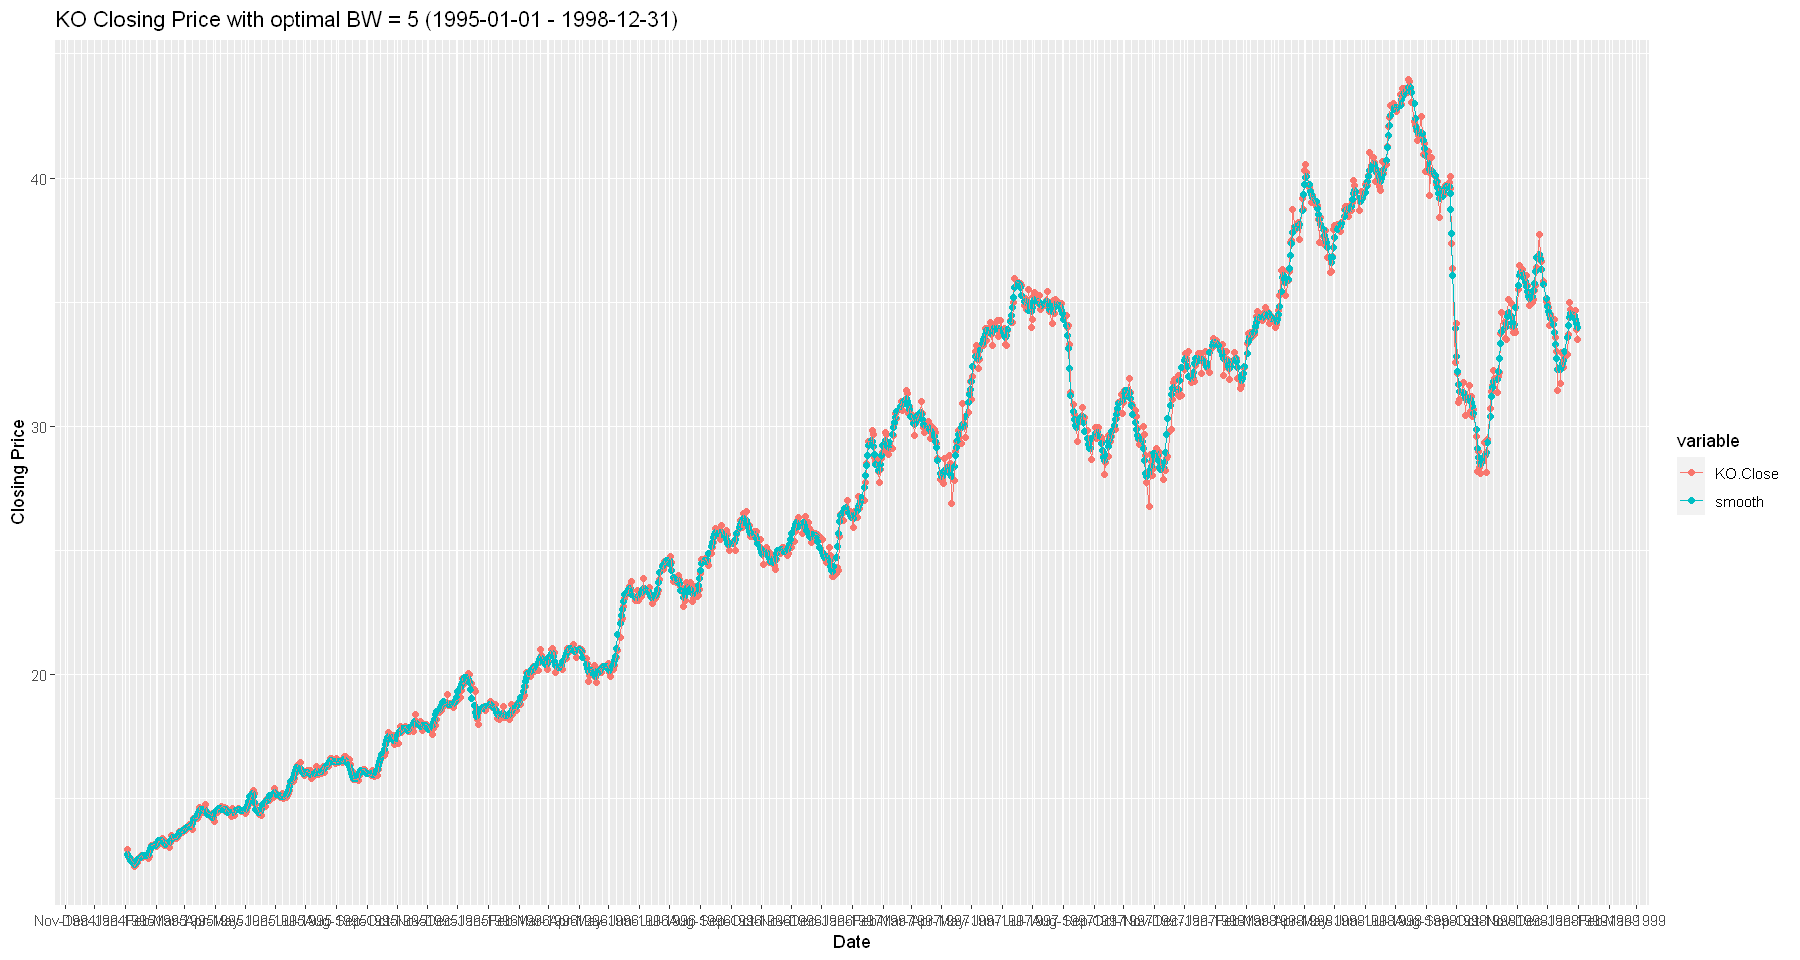

[1] "bandwidth = 5 mse = 0.634773042277768"
[1] "bandwidth = 10 mse = 0.515028473739643"
[1] "bandwidth = 20 mse = 0.51339544152722"
[1] "bandwidth = 40 mse = 0.756925918422969"
[1] "bandwidth = 60 mse = 1.09314668985789"
[1] "bandwidth = 250 mse = 3.97112345891985"
[1] "min bandwidth = 15 min mse = 0.490436999394421"


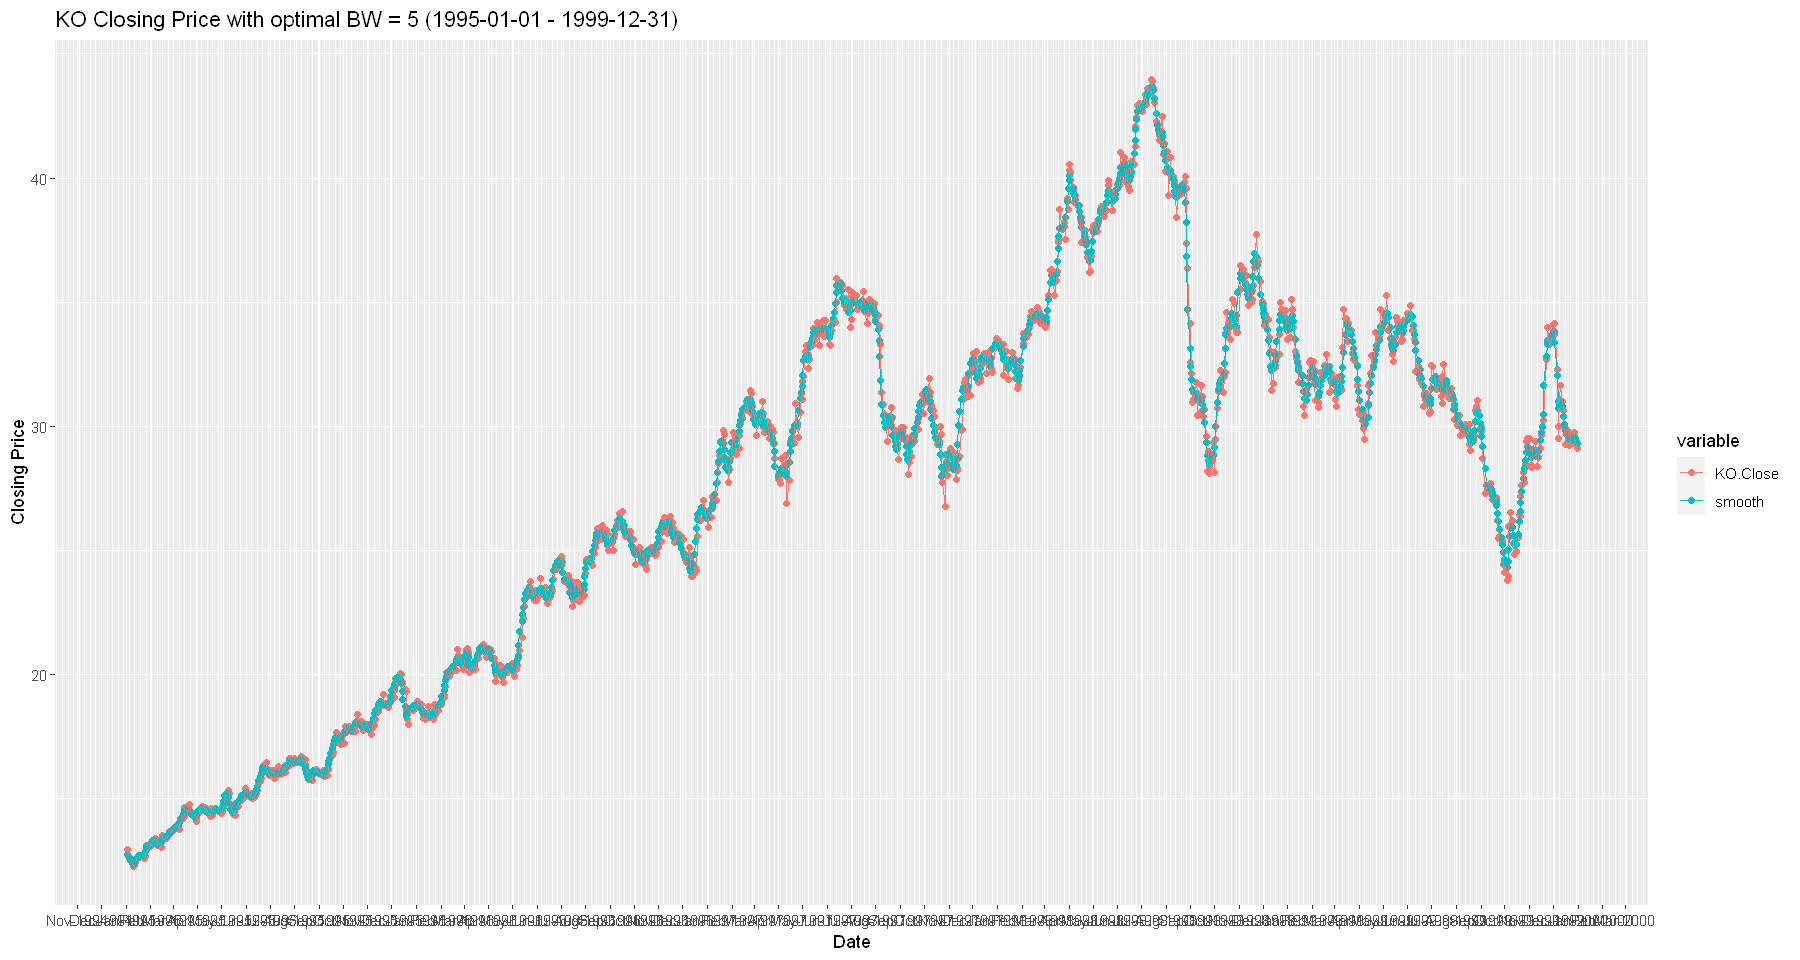

[1] "bandwidth = 5 mse = 0.725711547223501"
[1] "bandwidth = 10 mse = 0.594731268451403"
[1] "bandwidth = 20 mse = 0.553258183136191"
[1] "bandwidth = 40 mse = 0.760149331374357"
[1] "bandwidth = 60 mse = 1.06199979406168"
[1] "bandwidth = 250 mse = 3.7997407732665"
[1] "min bandwidth = 15 min mse = 0.547431849888085"


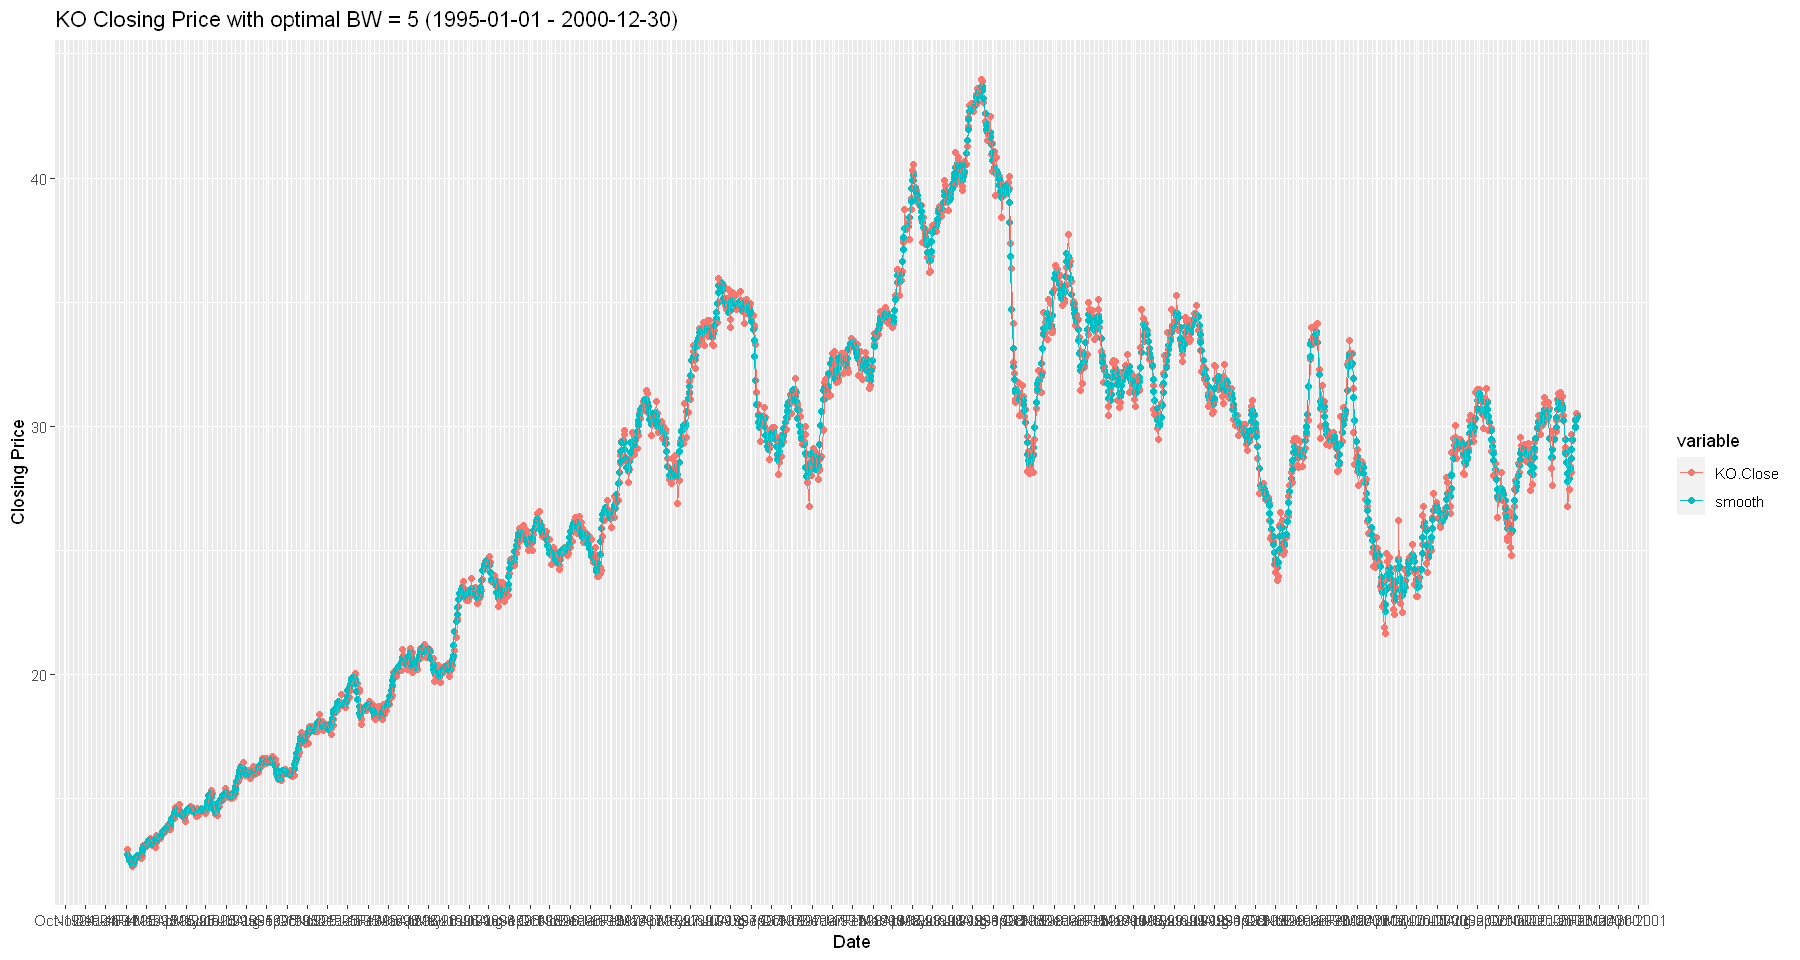

[1] "bandwidth = 5 mse = 0.629540653774777"
[1] "bandwidth = 10 mse = 0.518049602610223"
[1] "bandwidth = 20 mse = 0.493198331125042"
[1] "bandwidth = 40 mse = 0.69338676573092"
[1] "bandwidth = 60 mse = 0.97330241117421"
[1] "bandwidth = 250 mse = 3.49668192307736"
[1] "min bandwidth = 15 min mse = 0.482284717574889"


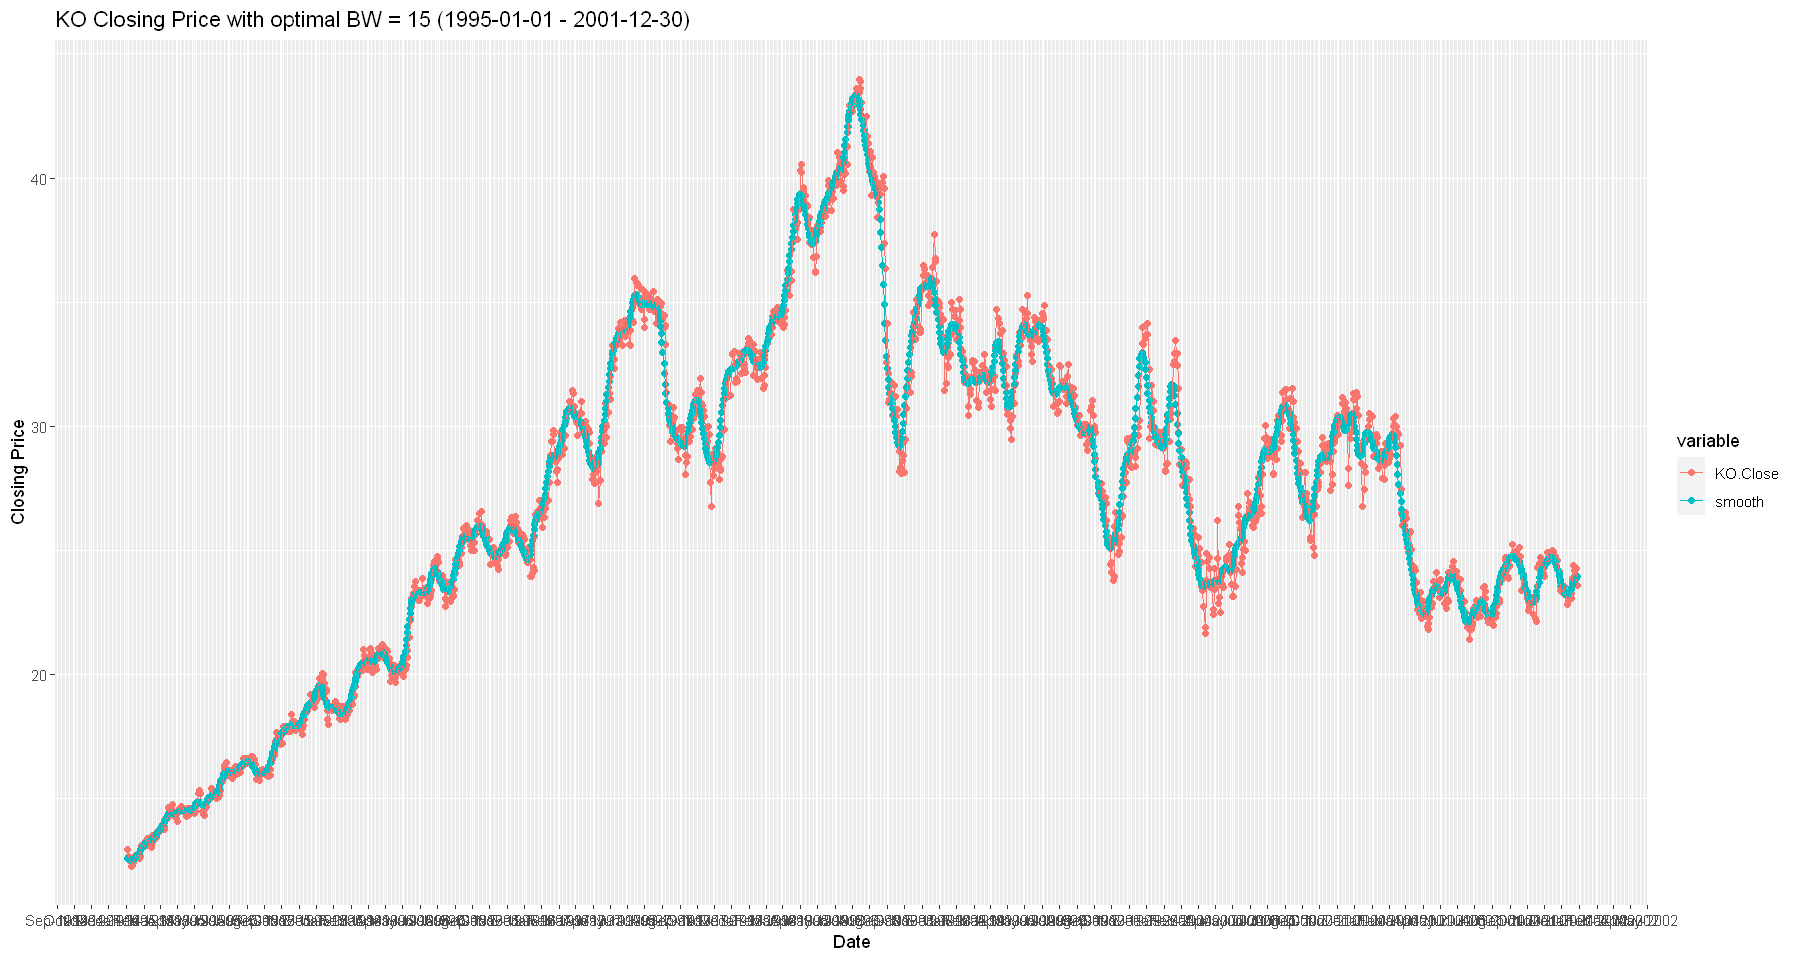

[1] "bandwidth = 5 mse = 0.633309393940593"
[1] "bandwidth = 10 mse = 0.524660542491551"
[1] "bandwidth = 20 mse = 0.486917902305323"
[1] "bandwidth = 40 mse = 0.663288944449057"
[1] "bandwidth = 60 mse = 0.917762452001685"
[1] "bandwidth = 250 mse = 3.29555523290659"
[1] "min bandwidth = 15 min mse = 0.4829123285836"


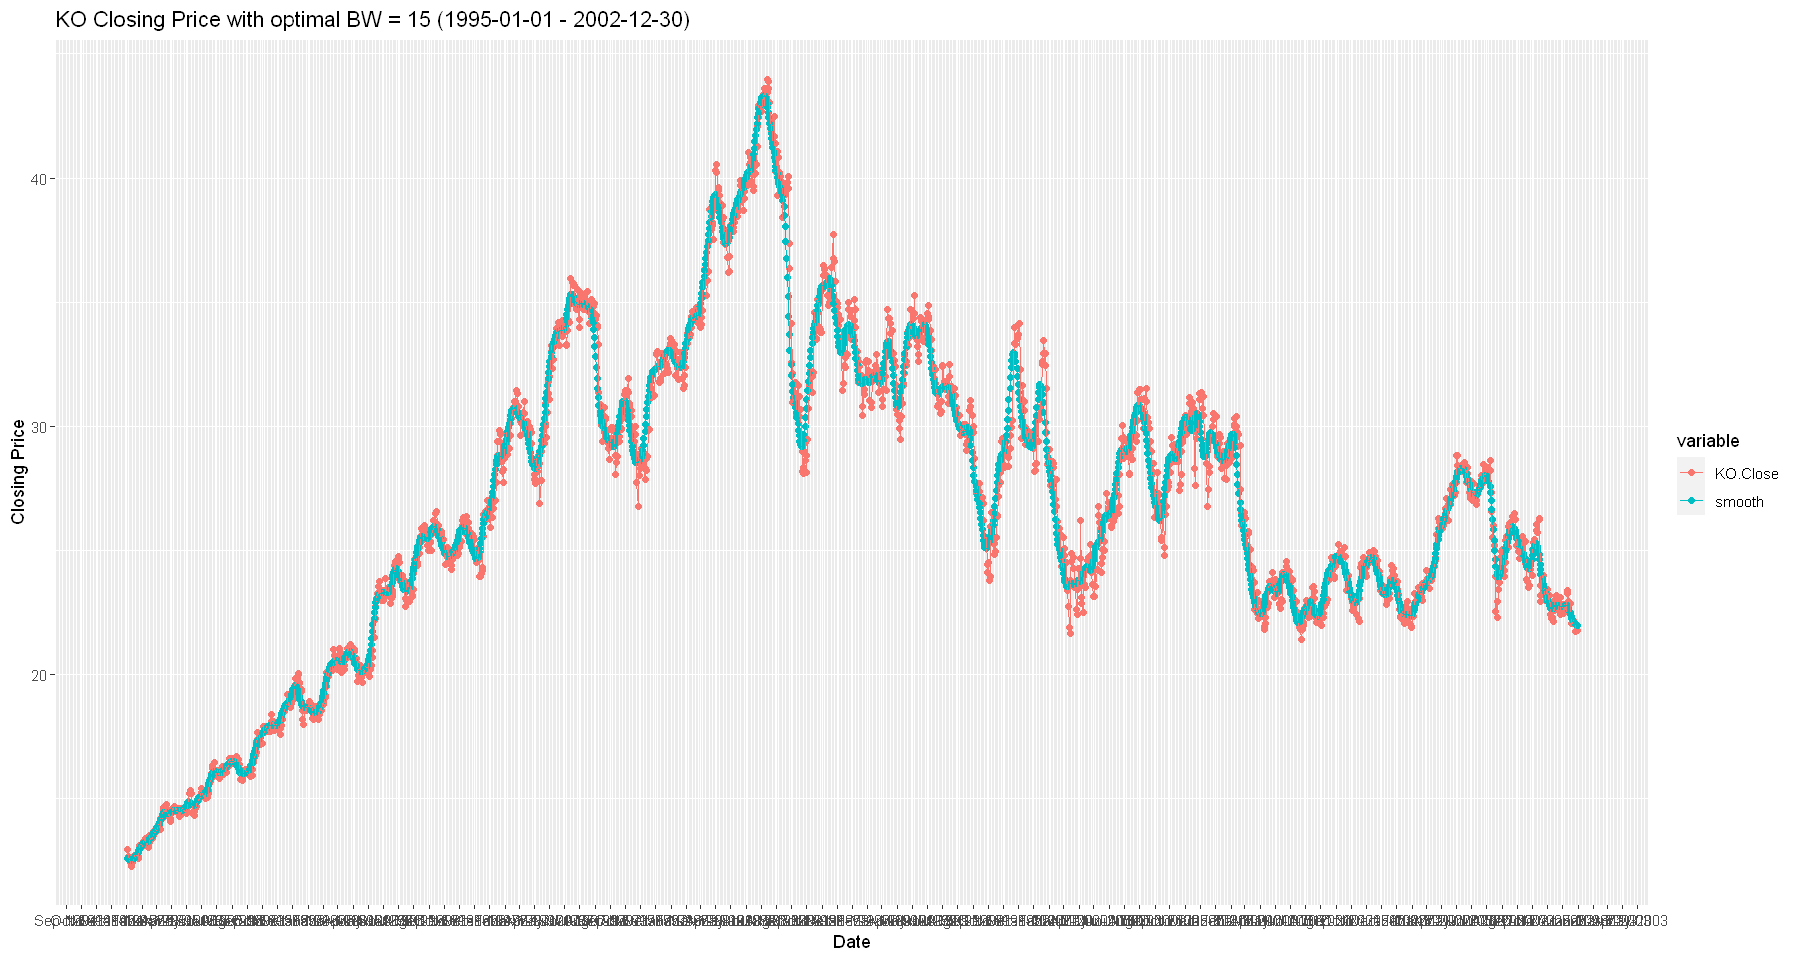

[1] "bandwidth = 5 mse = 0.50159857113011"
[1] "bandwidth = 10 mse = 0.414389118709216"
[1] "bandwidth = 20 mse = 0.405668546592819"
[1] "bandwidth = 40 mse = 0.587348491647466"
[1] "bandwidth = 60 mse = 0.829349058705253"
[1] "bandwidth = 250 mse = 3.00750570729781"
[1] "min bandwidth = 15 min mse = 0.391158634893658"


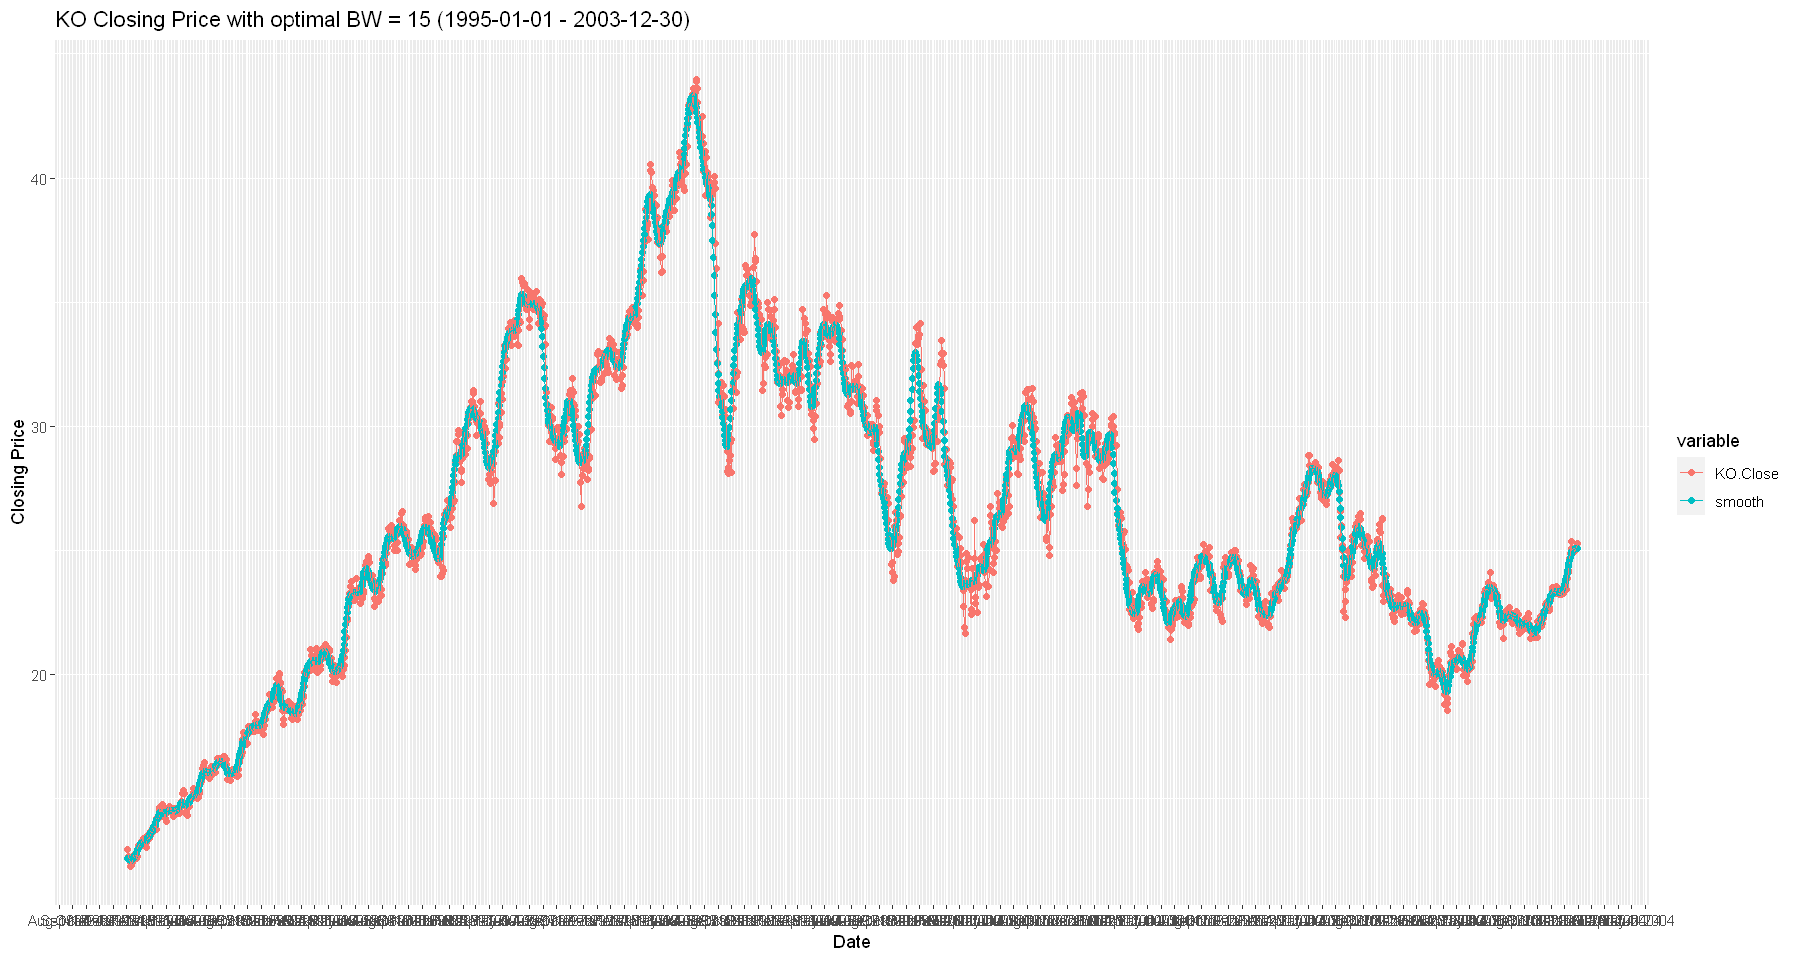

[1] "bandwidth = 5 mse = 0.485460042226443"
[1] "bandwidth = 10 mse = 0.400674102472695"
[1] "bandwidth = 20 mse = 0.39738691219865"
[1] "bandwidth = 40 mse = 0.582886571658427"
[1] "bandwidth = 60 mse = 0.82639470486588"
[1] "bandwidth = 250 mse = 3.00664864094867"
[1] "min bandwidth = 15 min mse = 0.380665102111191"


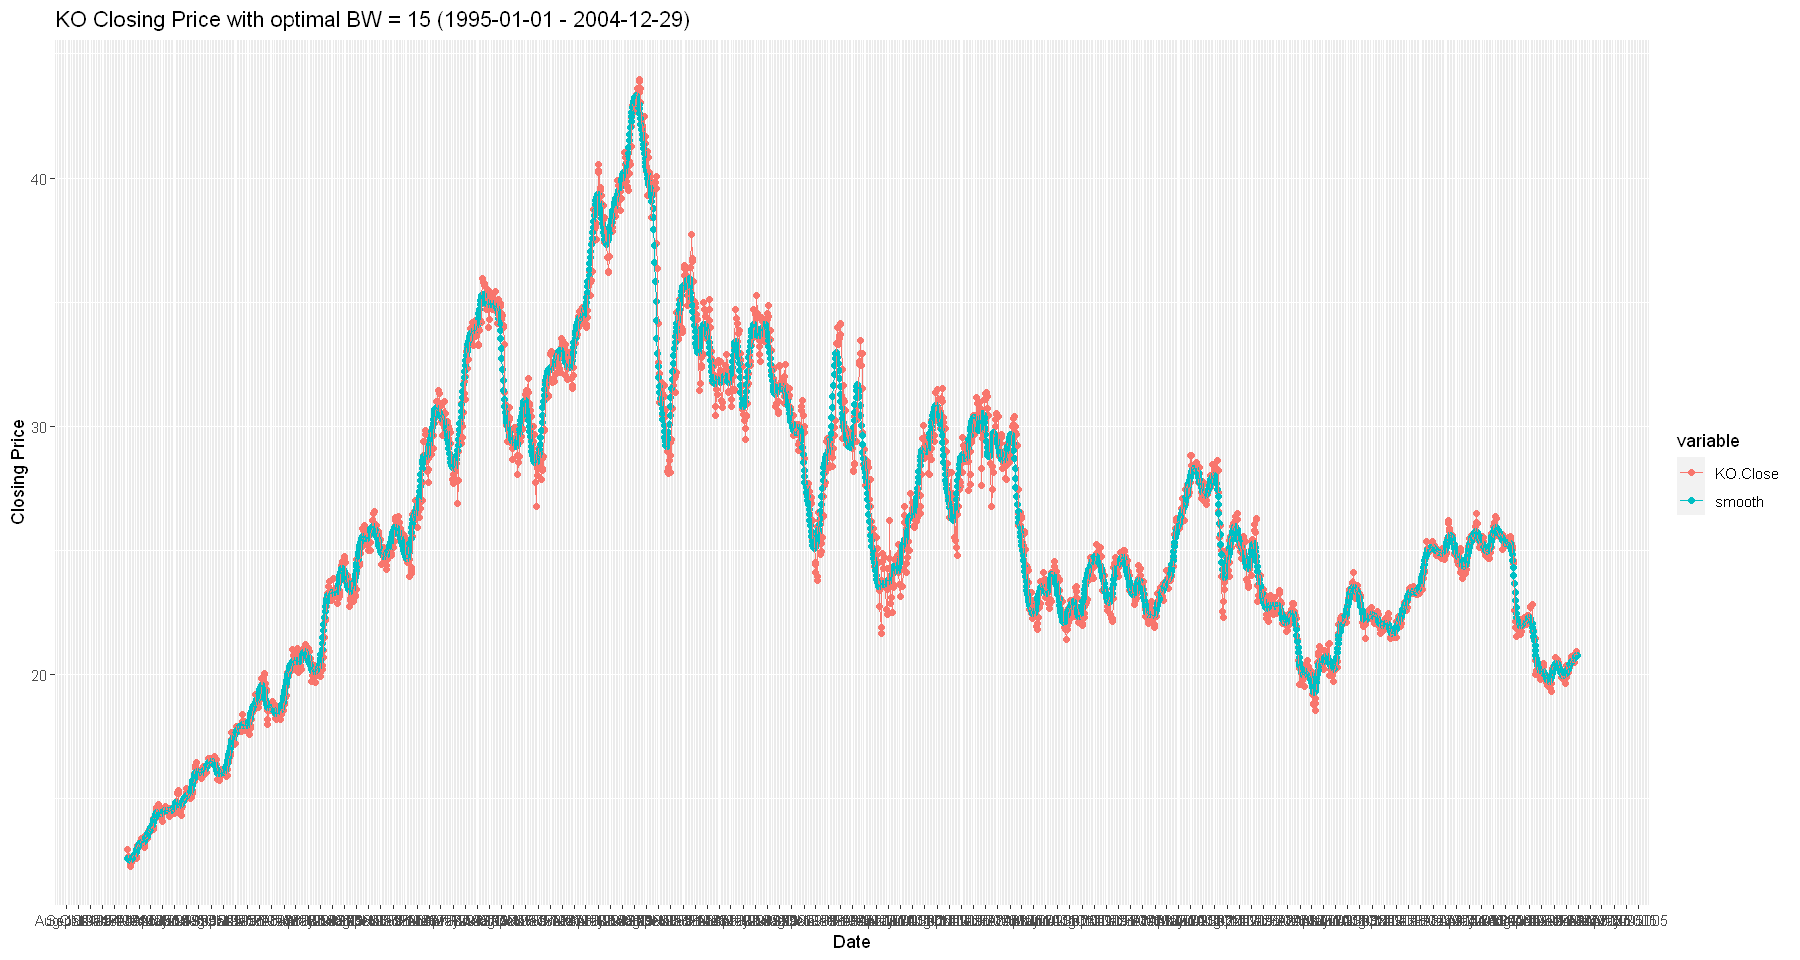

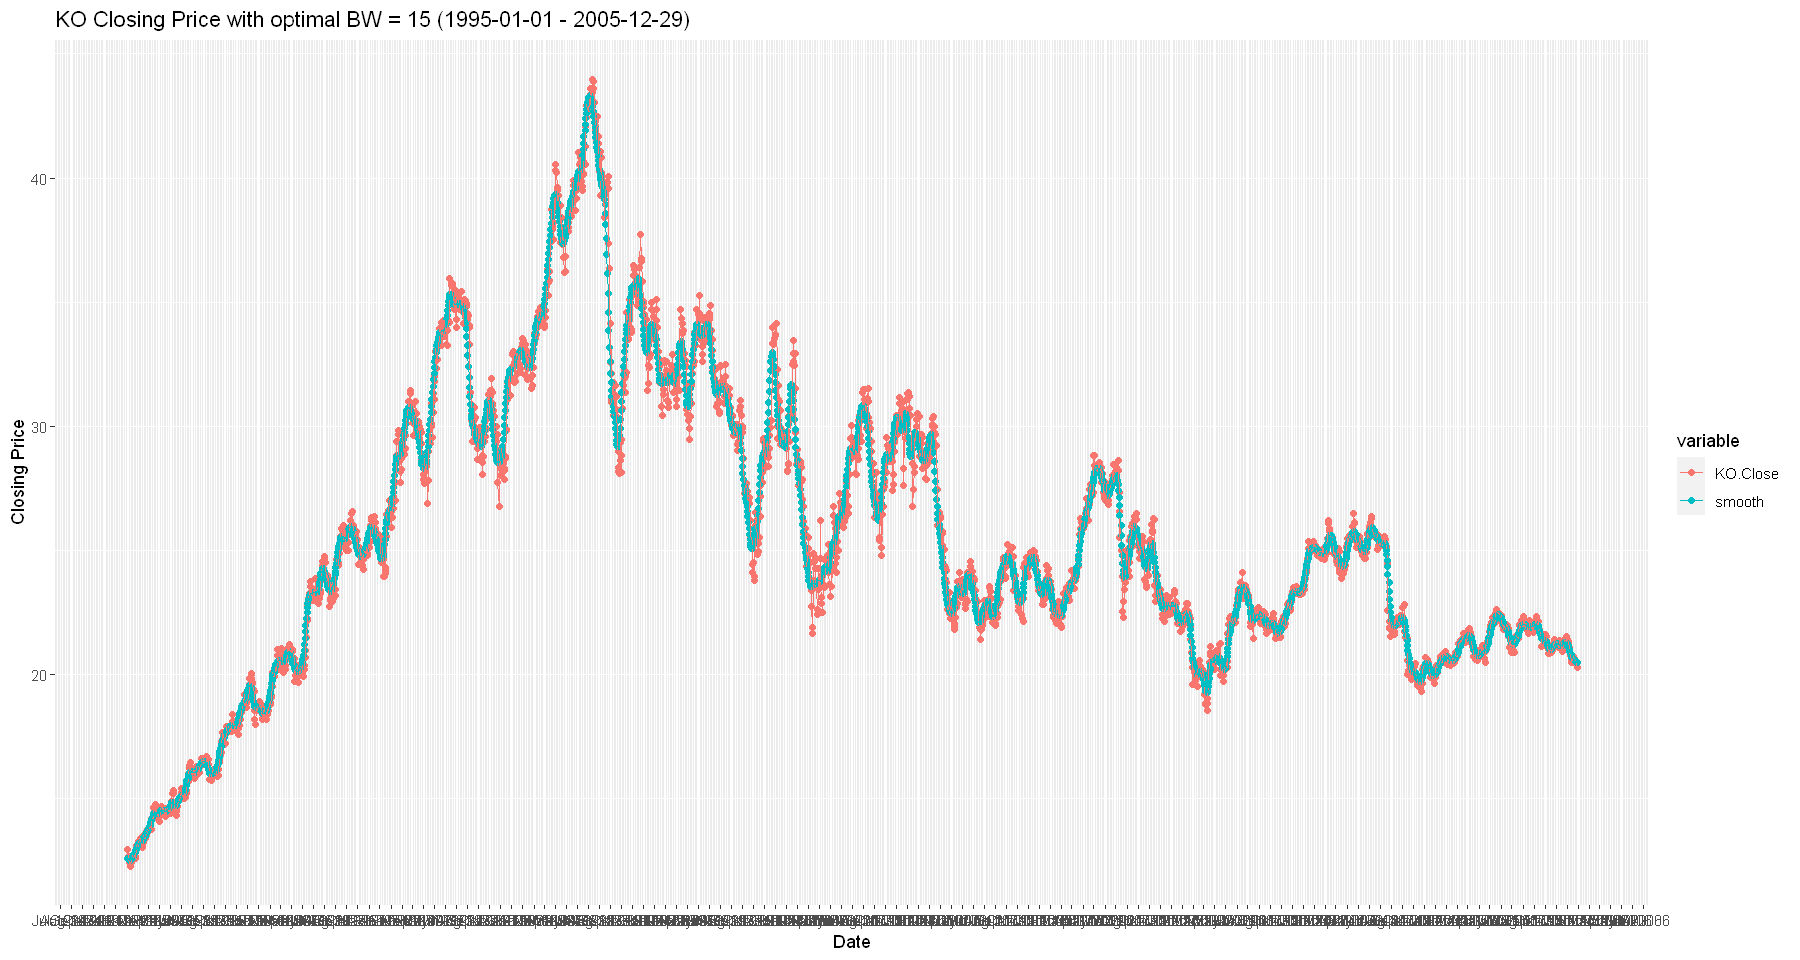

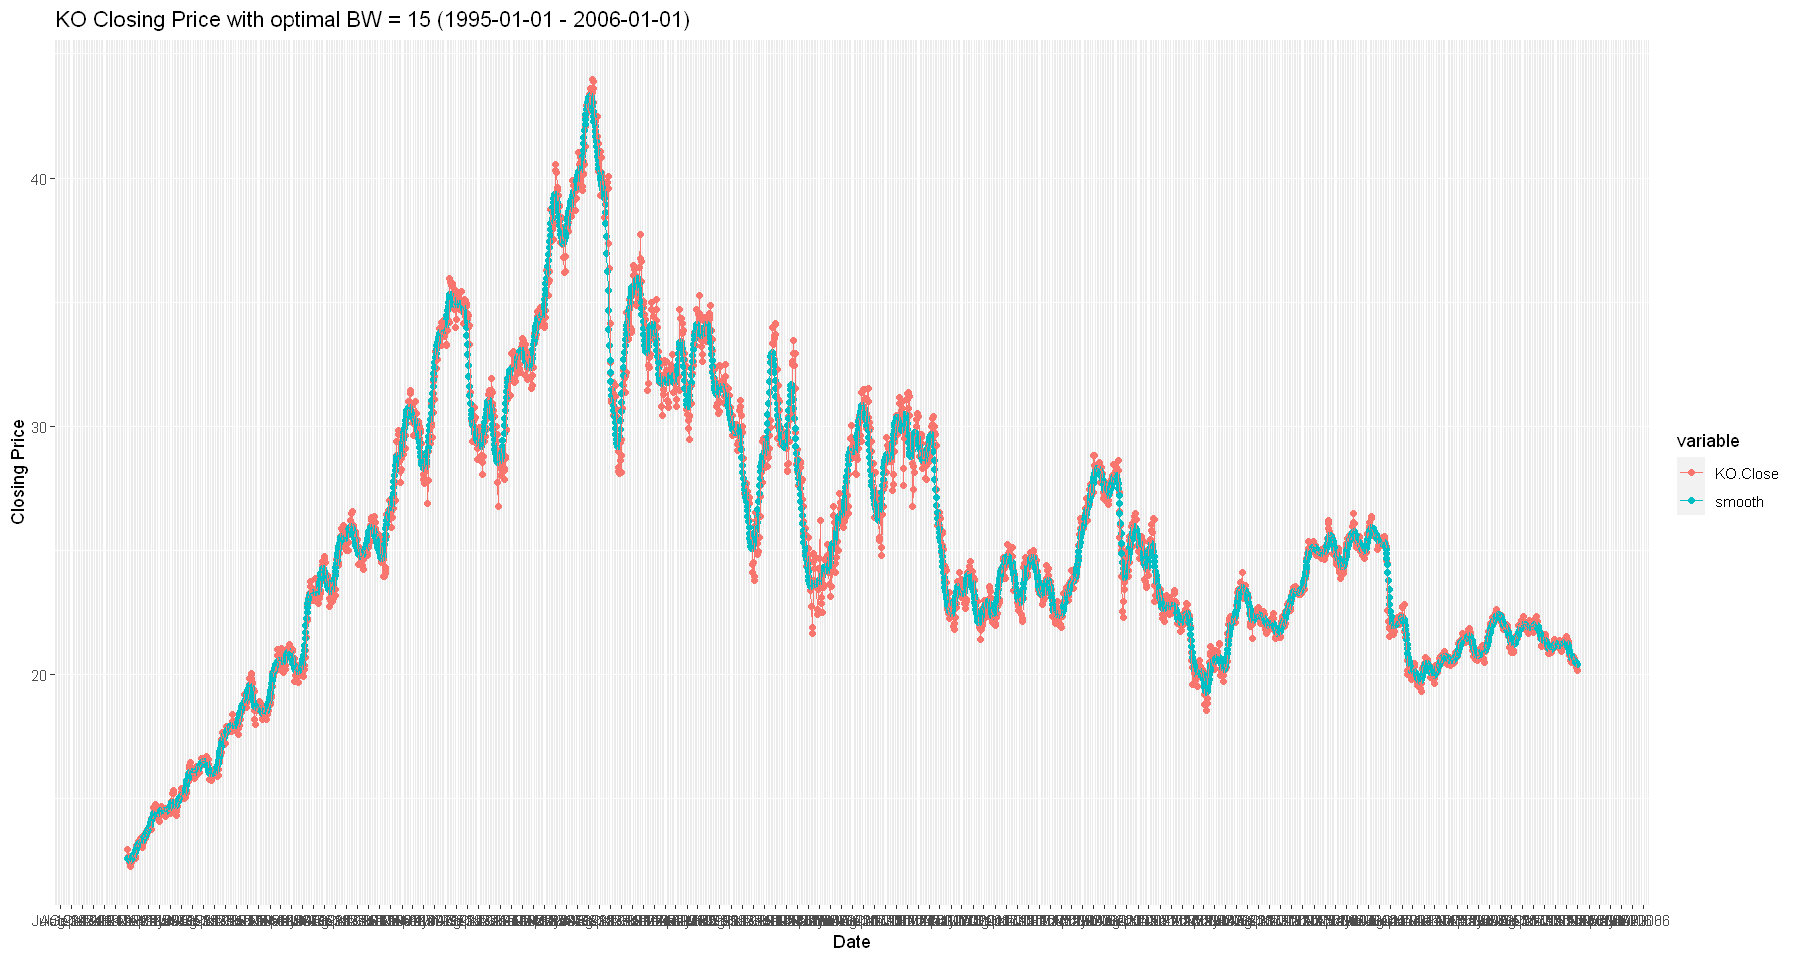

In [37]:
start_date <- "1995-01-01"
current_date <- start_date
end_date <- "2006-01-01"
date_step <- 365
while (current_date < end_date)
{
    current_date <- as.Date(current_date) + date_step
    if (current_date > end_date)
        current_date <- end_date
    plot <- calc_and_plot_best_bw(KO_closing, start_date, current_date)
    print(plot)
}

[1] "bandwidth = 5 mse = 0.0112041493302499"
[1] "bandwidth = 10 mse = 0.0217972090984538"
[1] "bandwidth = 20 mse = 0.0472326458297367"
[1] "bandwidth = 40 mse = 0.0826472782853092"
[1] "bandwidth = 60 mse = 0.11313863248295"
[1] "bandwidth = 250 mse = 0.676275836620639"
[1] "min bandwidth = 5 min mse = 0.0112041493302499"
[1] "bandwidth = 5 mse = 0.0457022395189288"
[1] "bandwidth = 10 mse = 0.0679159914728481"
[1] "bandwidth = 20 mse = 0.127304975930631"
[1] "bandwidth = 40 mse = 0.273056613374398"
[1] "bandwidth = 60 mse = 0.396823598852305"
[1] "bandwidth = 250 mse = 1.33934728427321"
[1] "min bandwidth = 5 min mse = 0.0457022395189288"
[1] "bandwidth = 5 mse = 0.105066838561318"
[1] "bandwidth = 10 mse = 0.182687872703889"
[1] "bandwidth = 20 mse = 0.324833457448938"
[1] "bandwidth = 40 mse = 0.688917940356004"
[1] "bandwidth = 60 mse = 1.15842128929211"
[1] "bandwidth = 250 mse = 4.68342357706176"
[1] "min bandwidth = 5 min mse = 0.105066838561318"


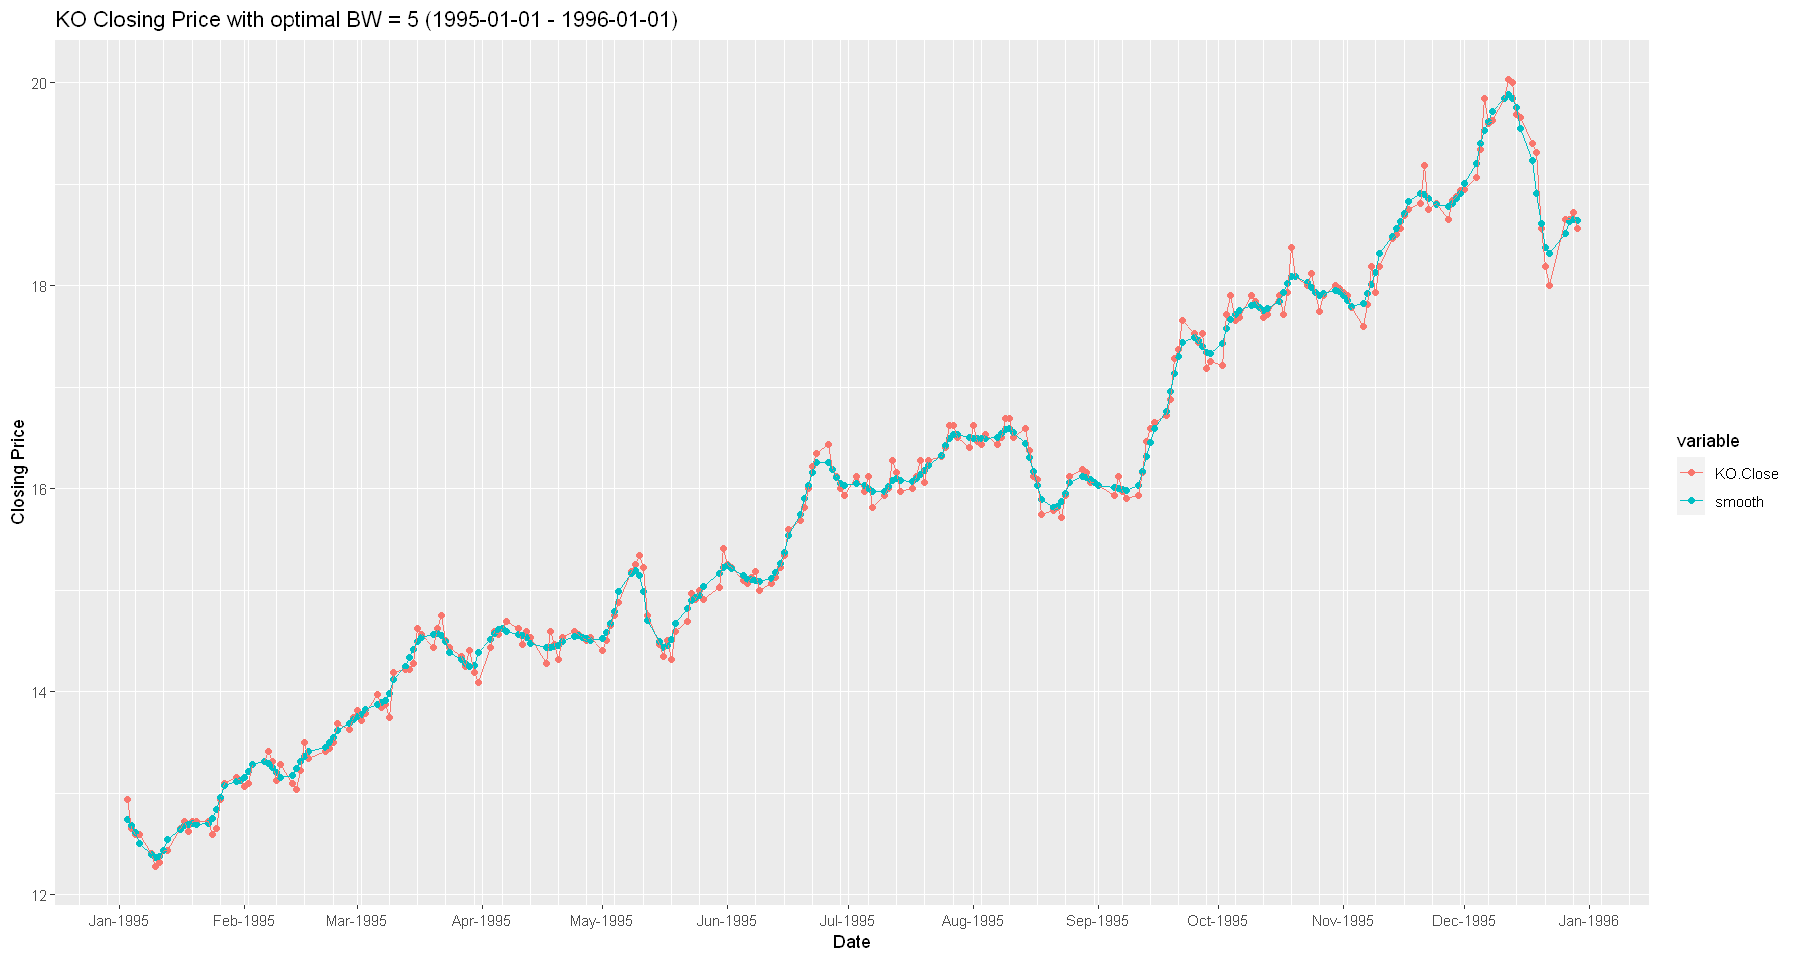

[1] "bandwidth = 5 mse = 0.196221221628224"
[1] "bandwidth = 10 mse = 0.297584861059874"
[1] "bandwidth = 20 mse = 0.574004262100509"
[1] "bandwidth = 40 mse = 1.21375501943025"
[1] "bandwidth = 60 mse = 2.14419468888457"
[1] "bandwidth = 250 mse = 10.7100746577127"
[1] "min bandwidth = 5 min mse = 0.196221221628224"


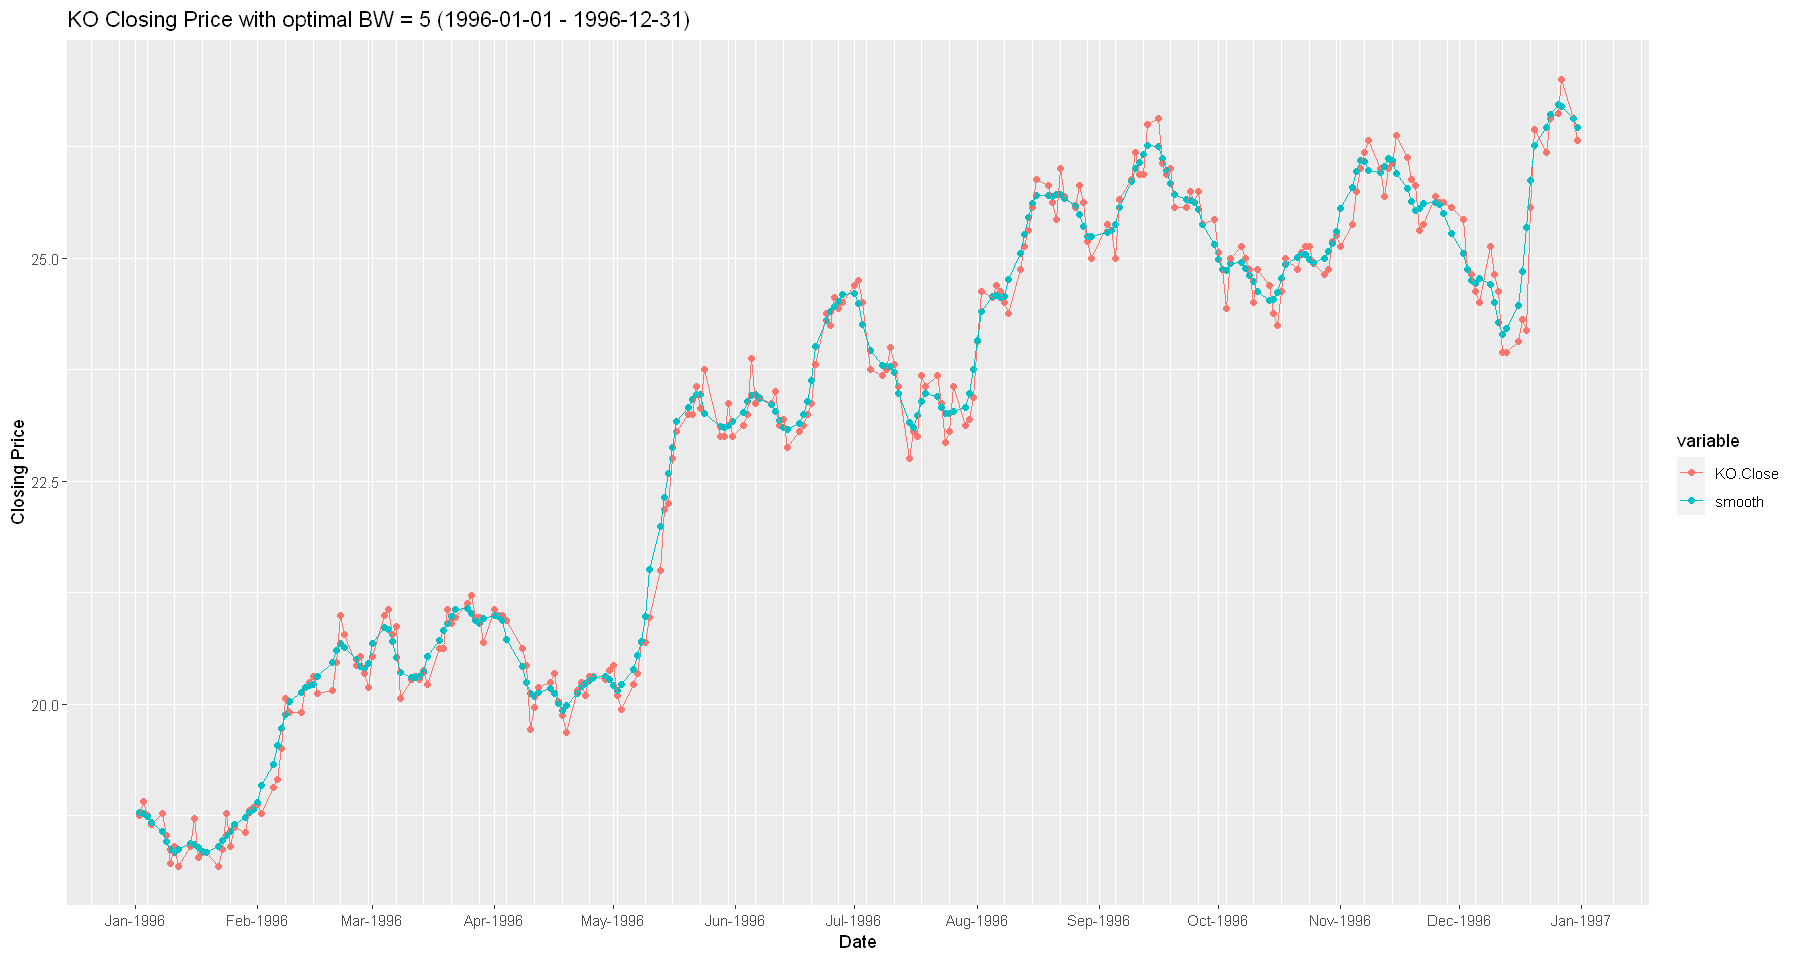

[1] "bandwidth = 5 mse = 0.226229559528228"
[1] "bandwidth = 10 mse = 0.301720514698442"
[1] "bandwidth = 20 mse = 0.529022960610815"
[1] "bandwidth = 40 mse = 1.04441730043922"
[1] "bandwidth = 60 mse = 1.48019291548065"
[1] "bandwidth = 250 mse = 4.07682748572459"
[1] "min bandwidth = 5 min mse = 0.226229559528228"


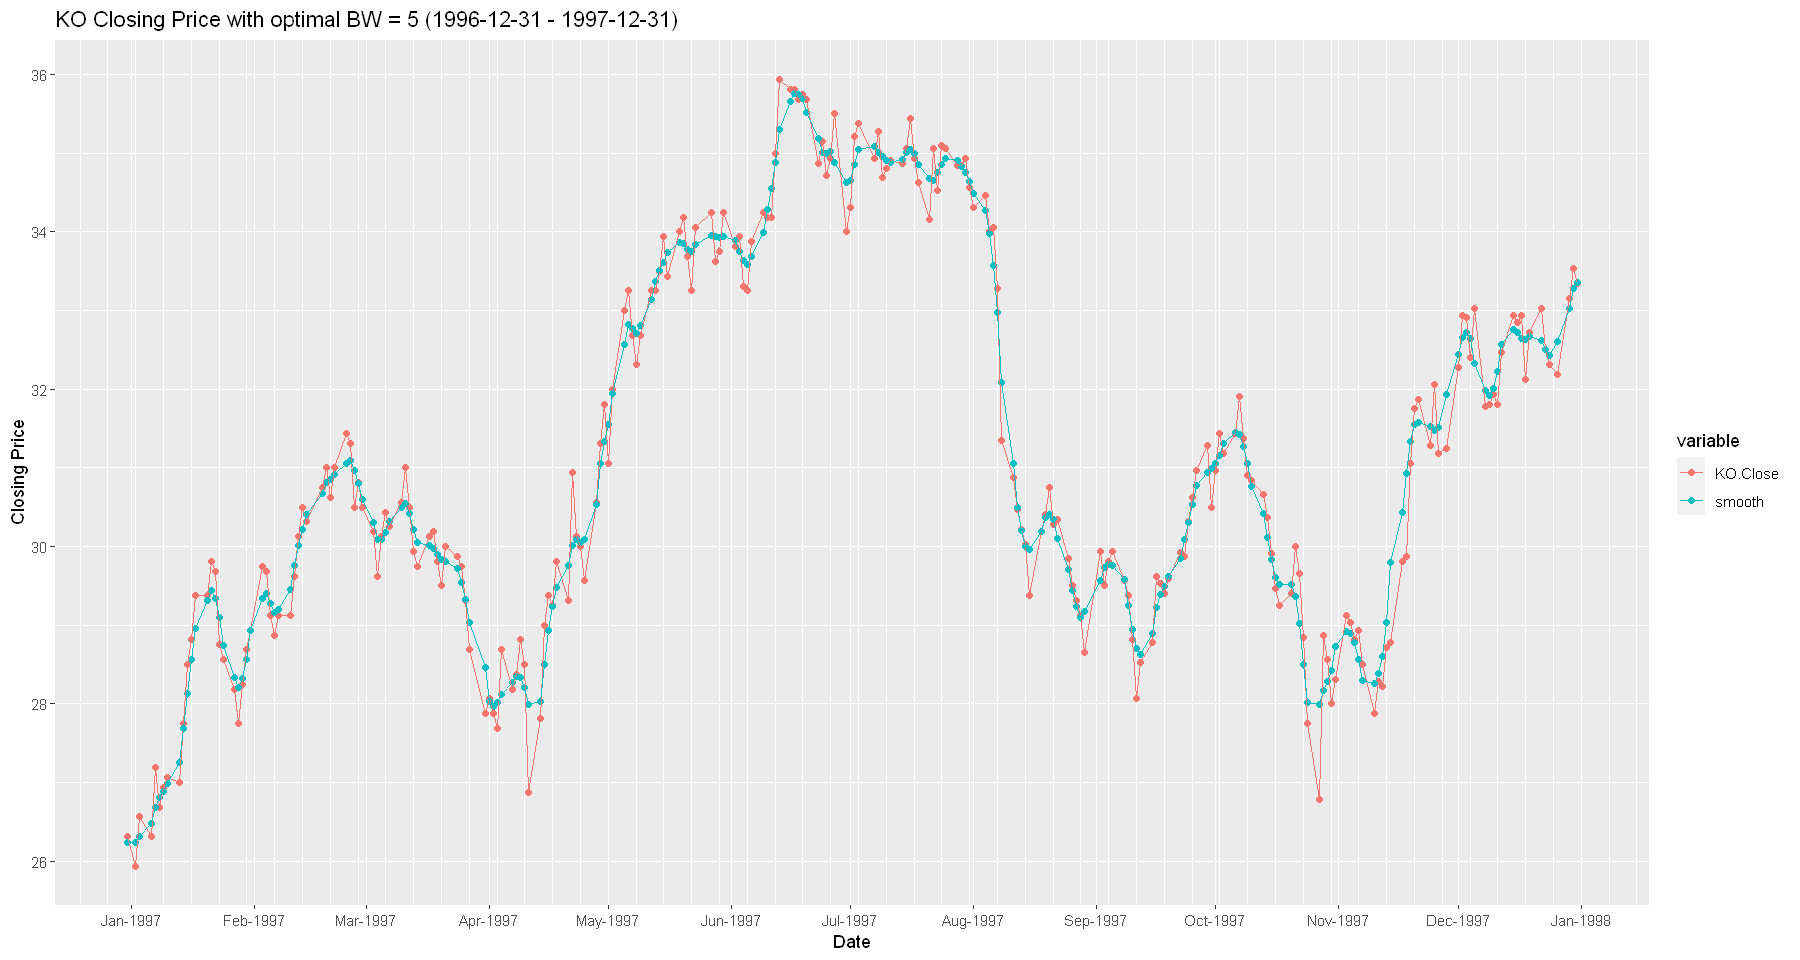

[1] "bandwidth = 5 mse = 0.23852834413829"
[1] "bandwidth = 10 mse = 0.368409504827237"
[1] "bandwidth = 20 mse = 0.654247125211288"
[1] "bandwidth = 40 mse = 1.03935210296483"
[1] "bandwidth = 60 mse = 1.44072312724218"
[1] "bandwidth = 250 mse = 4.99264452720951"
[1] "min bandwidth = 5 min mse = 0.23852834413829"


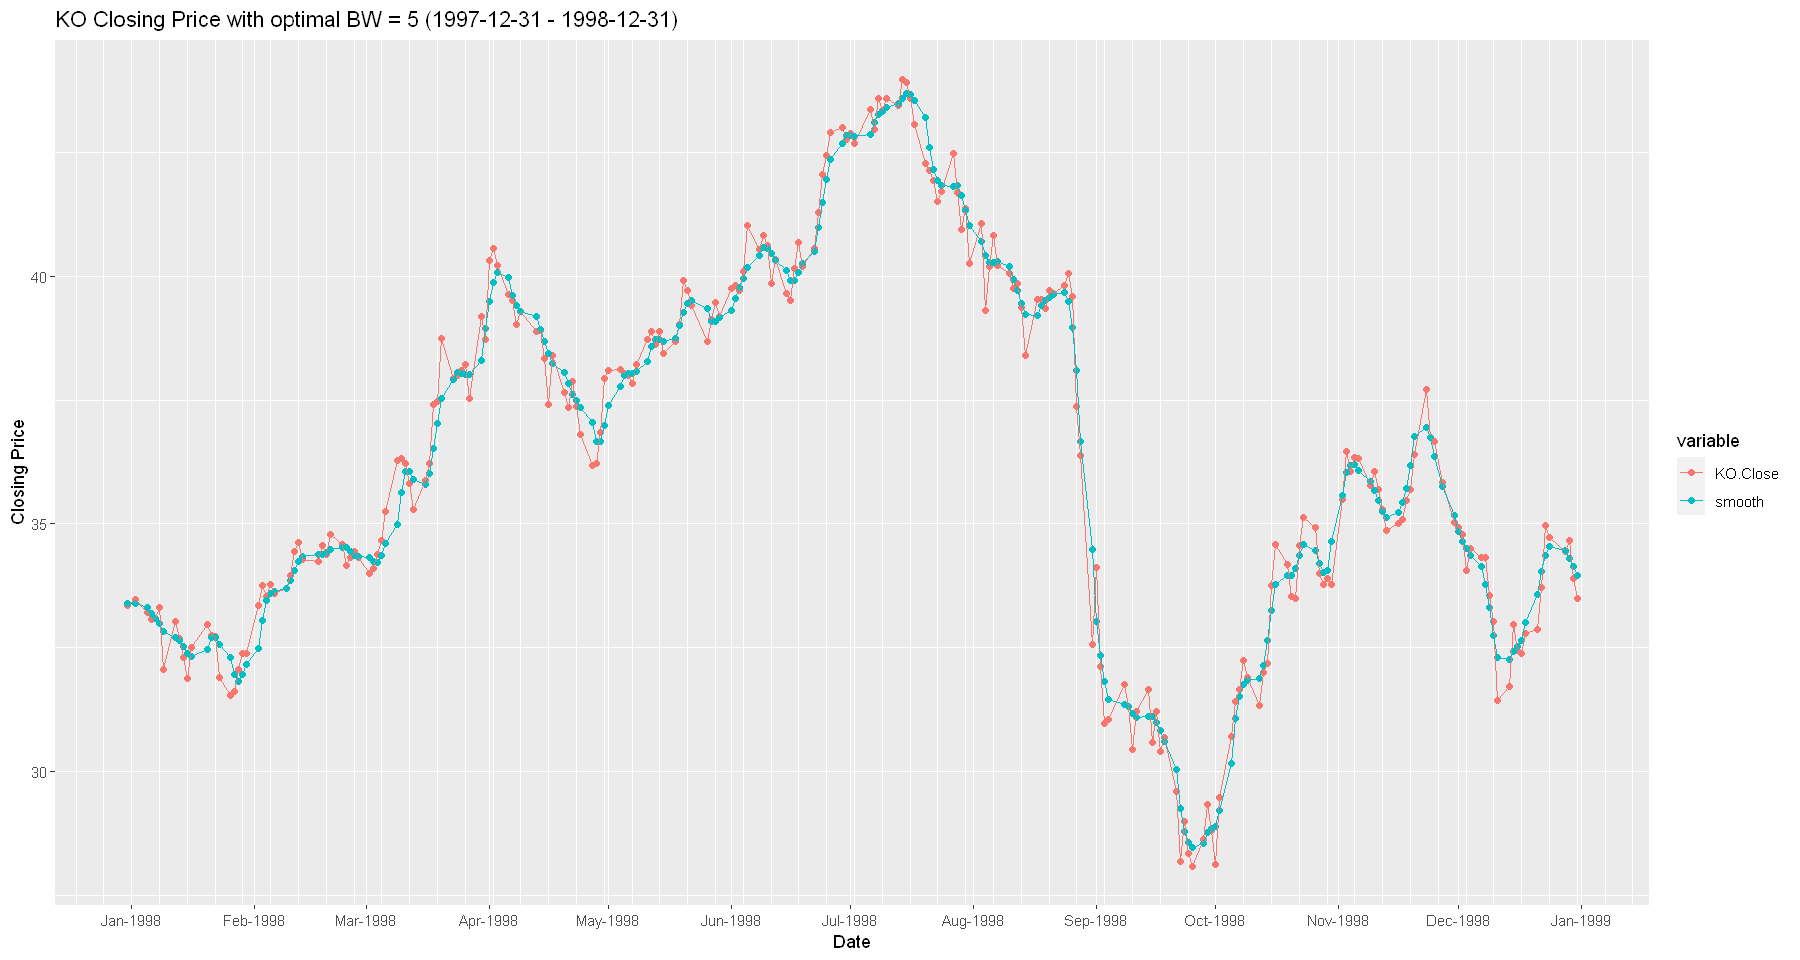

[1] "bandwidth = 5 mse = 0.0933096900270904"
[1] "bandwidth = 10 mse = 0.123143223988826"
[1] "bandwidth = 20 mse = 0.203090181792104"
[1] "bandwidth = 40 mse = 0.427160677179845"
[1] "bandwidth = 60 mse = 0.673207508852854"
[1] "bandwidth = 250 mse = 2.87811200566163"
[1] "min bandwidth = 5 min mse = 0.0933096900270904"


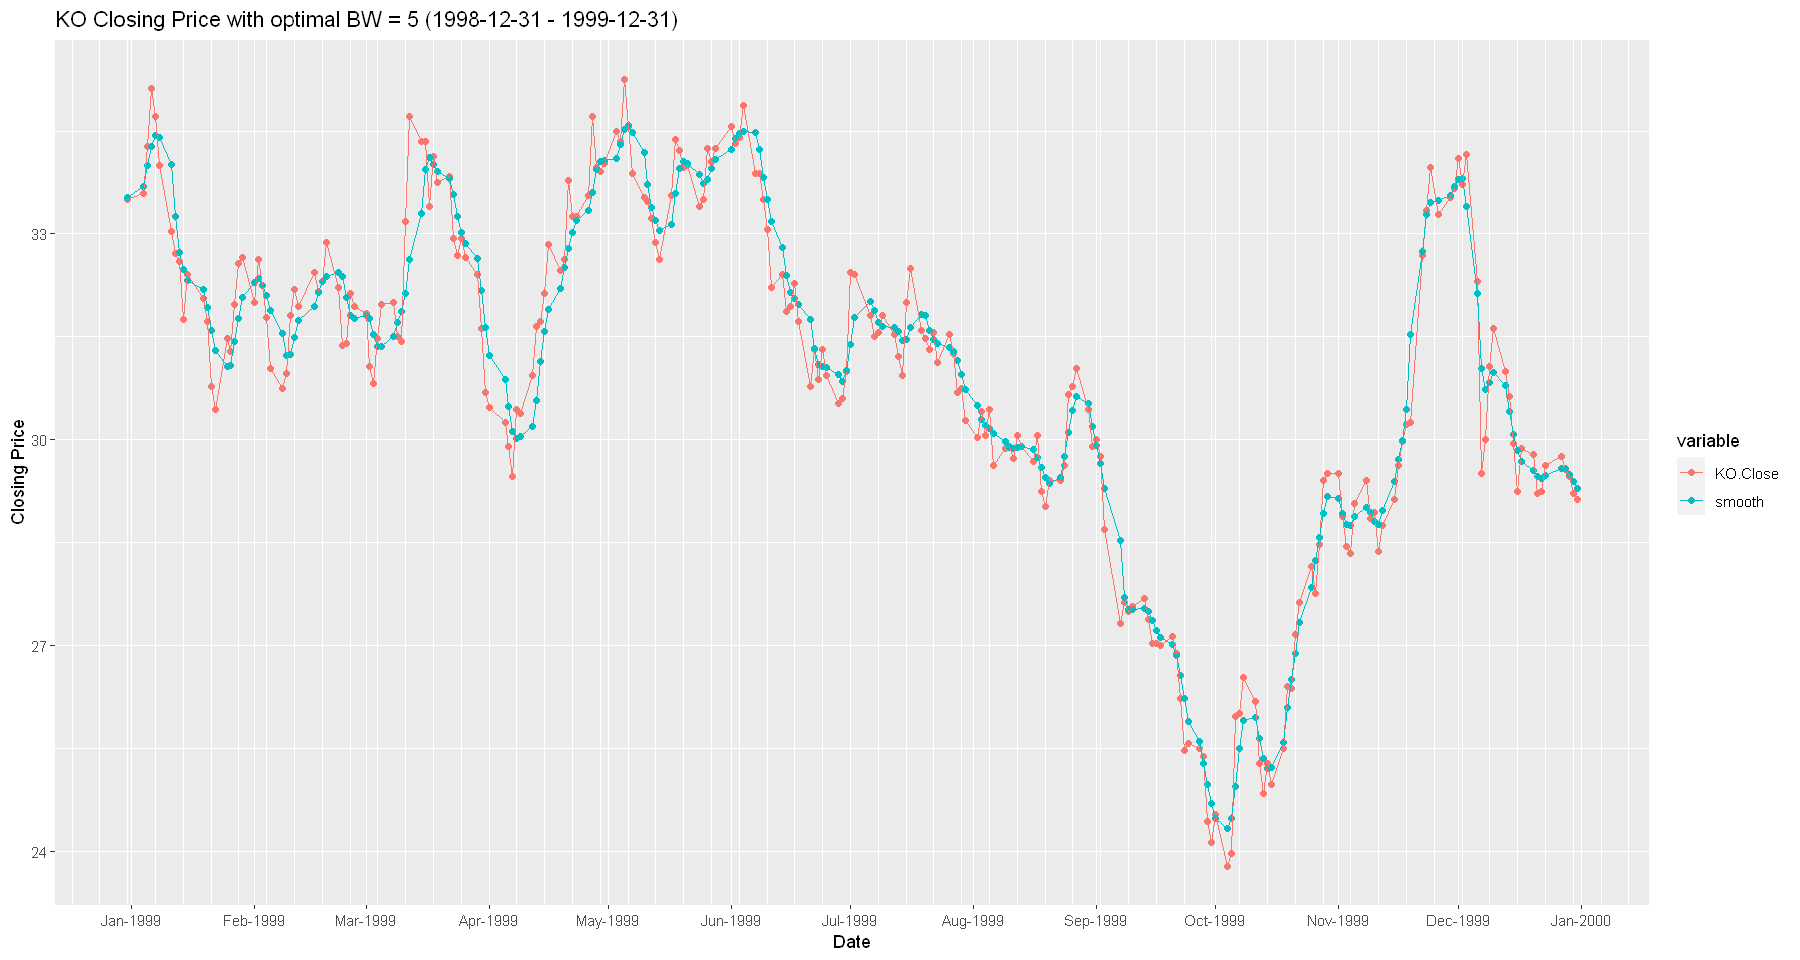

[1] "bandwidth = 5 mse = 0.0776868778206544"
[1] "bandwidth = 10 mse = 0.121675551323693"
[1] "bandwidth = 20 mse = 0.227868674856019"
[1] "bandwidth = 40 mse = 0.46795968649304"
[1] "bandwidth = 60 mse = 0.639735260673865"
[1] "bandwidth = 250 mse = 2.74546836716292"
[1] "min bandwidth = 5 min mse = 0.0776868778206544"


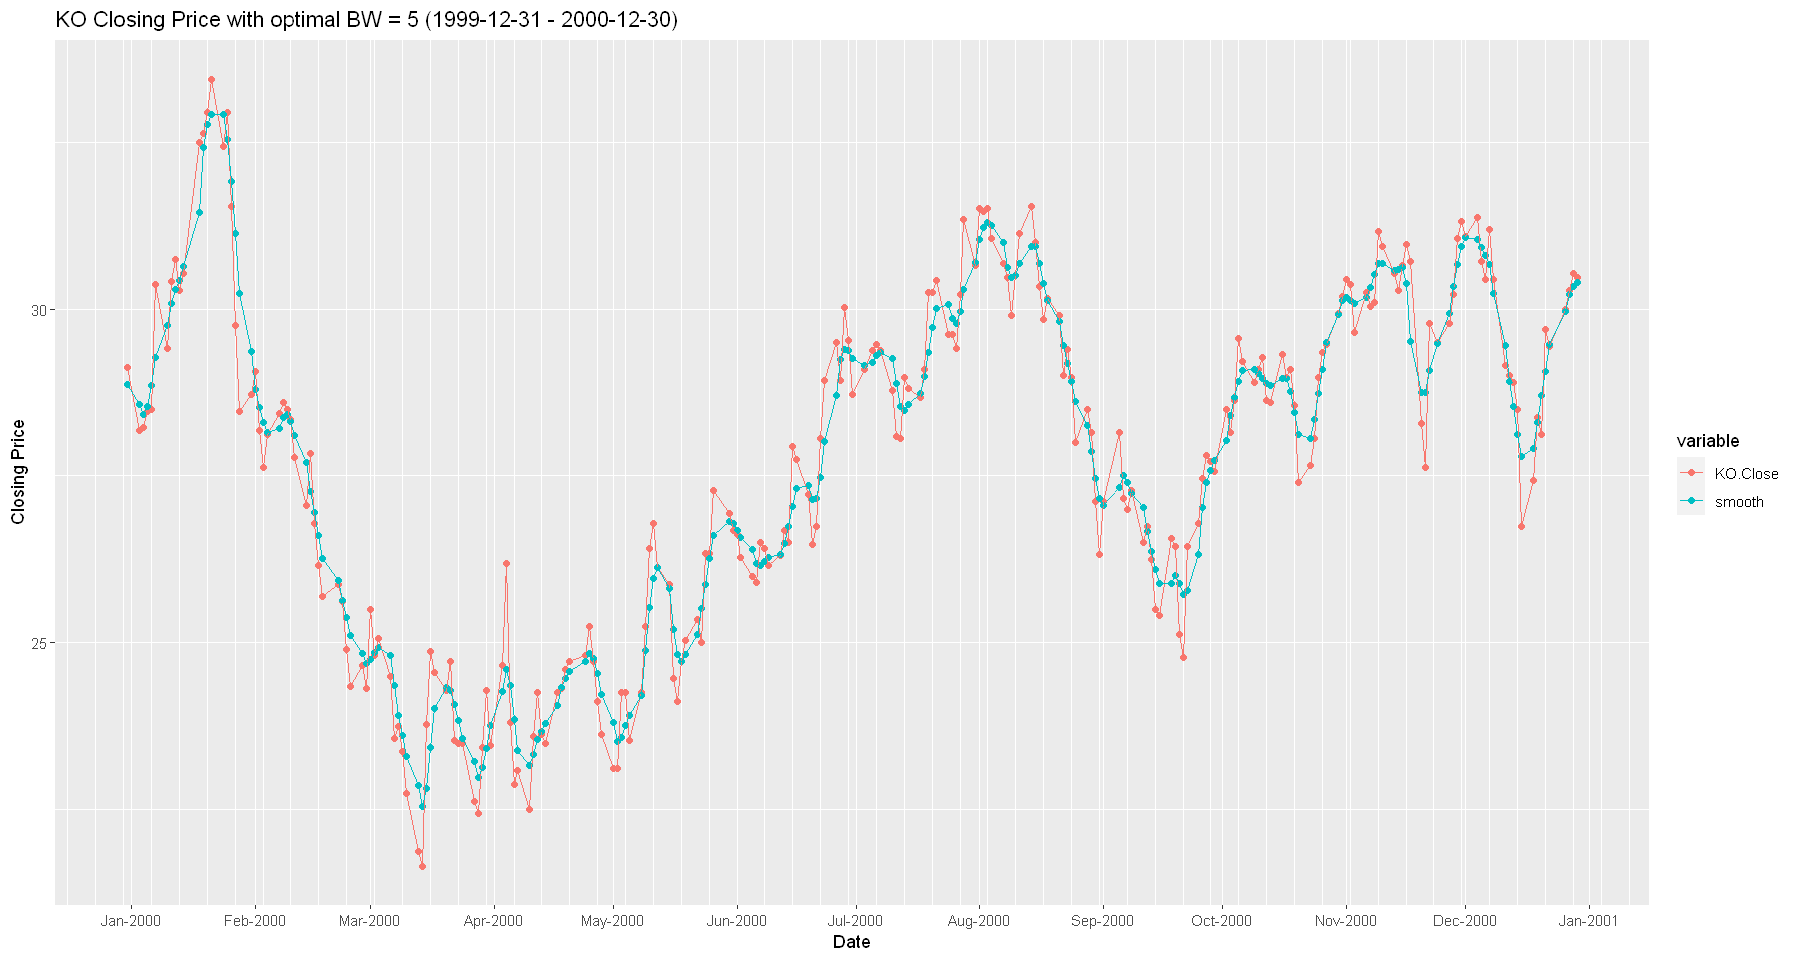

[1] "bandwidth = 5 mse = 0.0295317330263934"
[1] "bandwidth = 10 mse = 0.0465118786645198"
[1] "bandwidth = 20 mse = 0.0992119254974891"
[1] "bandwidth = 40 mse = 0.208581061079308"
[1] "bandwidth = 60 mse = 0.314540288771677"
[1] "bandwidth = 250 mse = 1.11467864349515"
[1] "min bandwidth = 5 min mse = 0.0295317330263934"


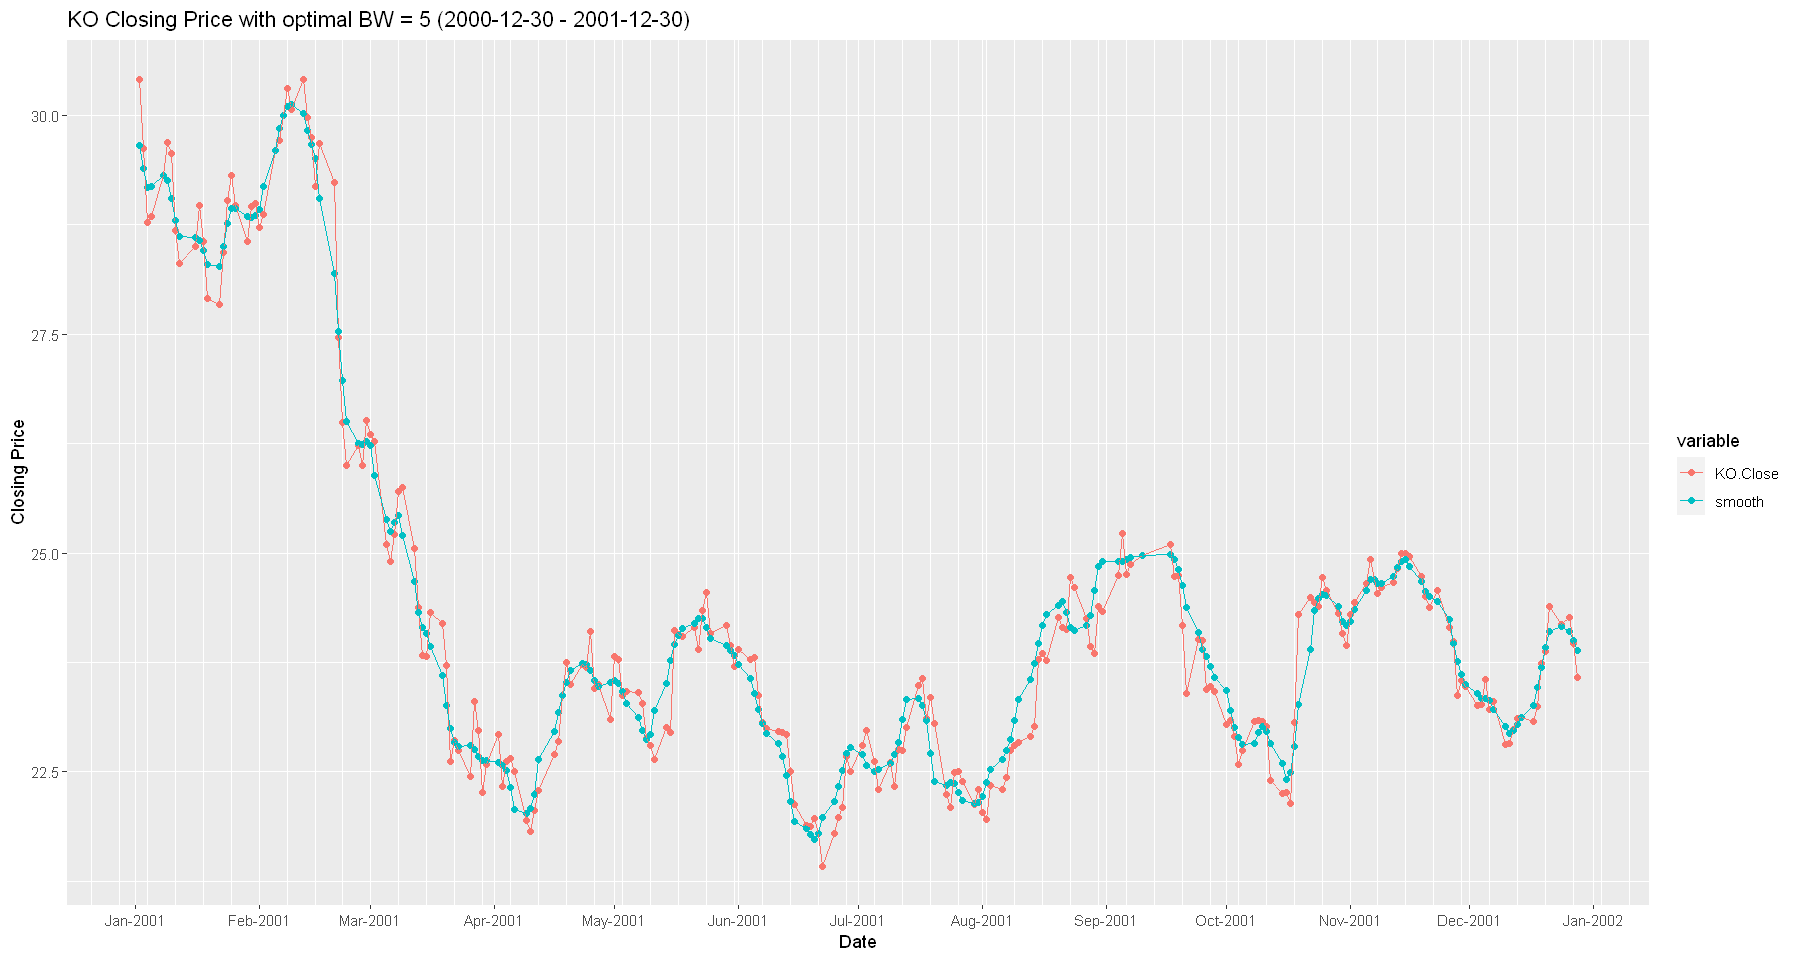

[1] "bandwidth = 5 mse = 0.0398927994068656"
[1] "bandwidth = 10 mse = 0.0532859020159028"
[1] "bandwidth = 20 mse = 0.101370820078801"
[1] "bandwidth = 40 mse = 0.222067874481104"
[1] "bandwidth = 60 mse = 0.315558934328056"
[1] "bandwidth = 250 mse = 1.42983237635964"
[1] "min bandwidth = 5 min mse = 0.0398927994068656"


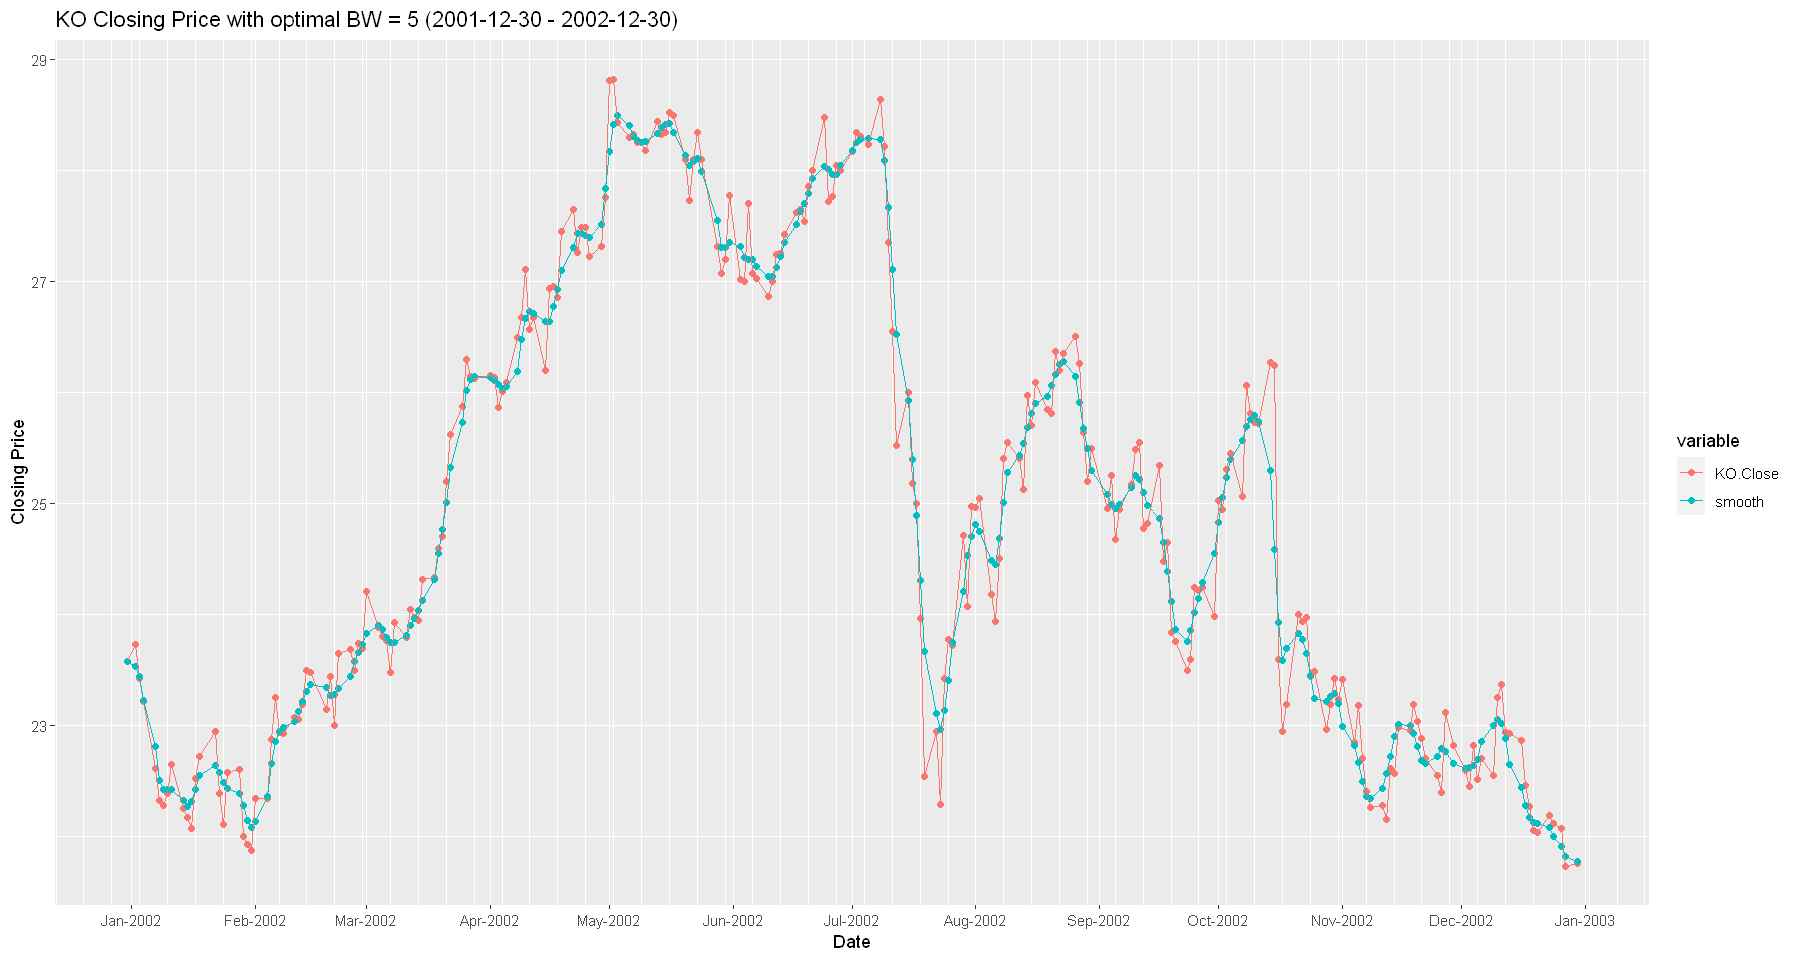

[1] "bandwidth = 5 mse = 0.00924297004947614"
[1] "bandwidth = 10 mse = 0.0149108542466743"
[1] "bandwidth = 20 mse = 0.0280588120093858"
[1] "bandwidth = 40 mse = 0.058263338248911"
[1] "bandwidth = 60 mse = 0.0966720746697045"
[1] "bandwidth = 250 mse = 0.230713961014506"
[1] "min bandwidth = 5 min mse = 0.00924297004947614"


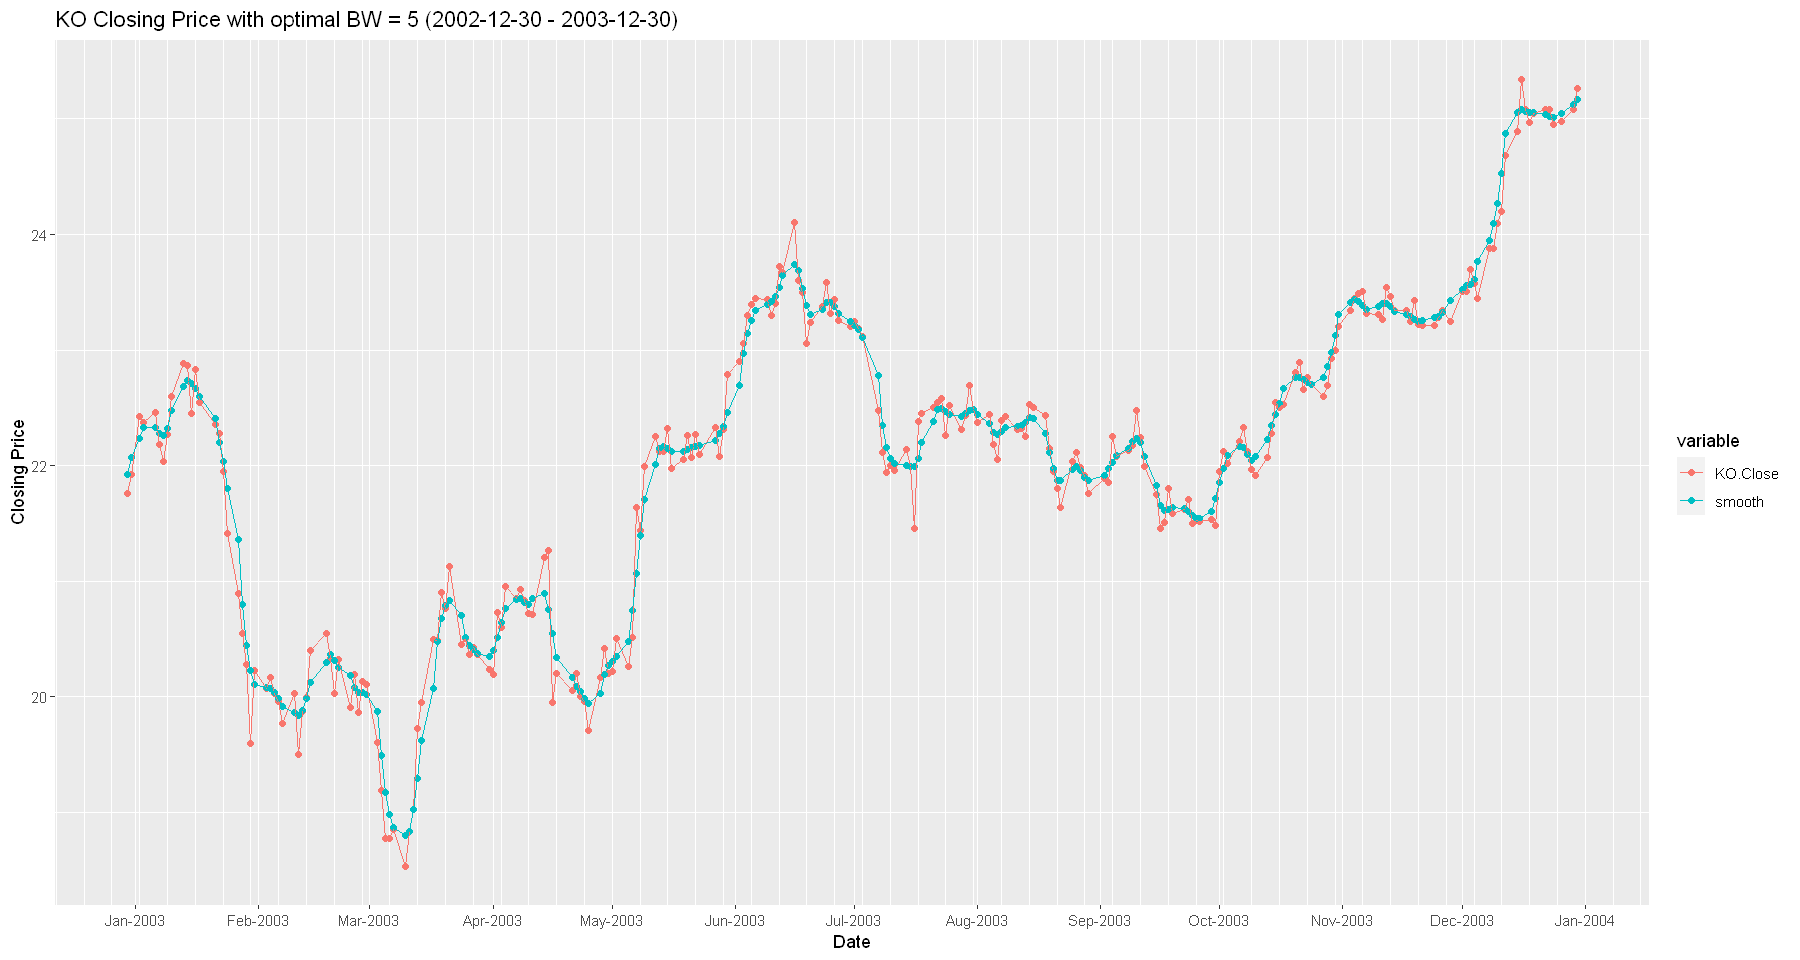

[1] "bandwidth = 5 mse = 0.0133446043490651"
[1] "bandwidth = 10 mse = 0.0184089527943821"
[1] "bandwidth = 20 mse = 0.0348344469821653"
[1] "bandwidth = 40 mse = 0.0619289366263896"
[1] "bandwidth = 60 mse = 0.0860694444216194"
[1] "bandwidth = 250 mse = 0.299081715703252"
[1] "min bandwidth = 5 min mse = 0.0133446043490651"


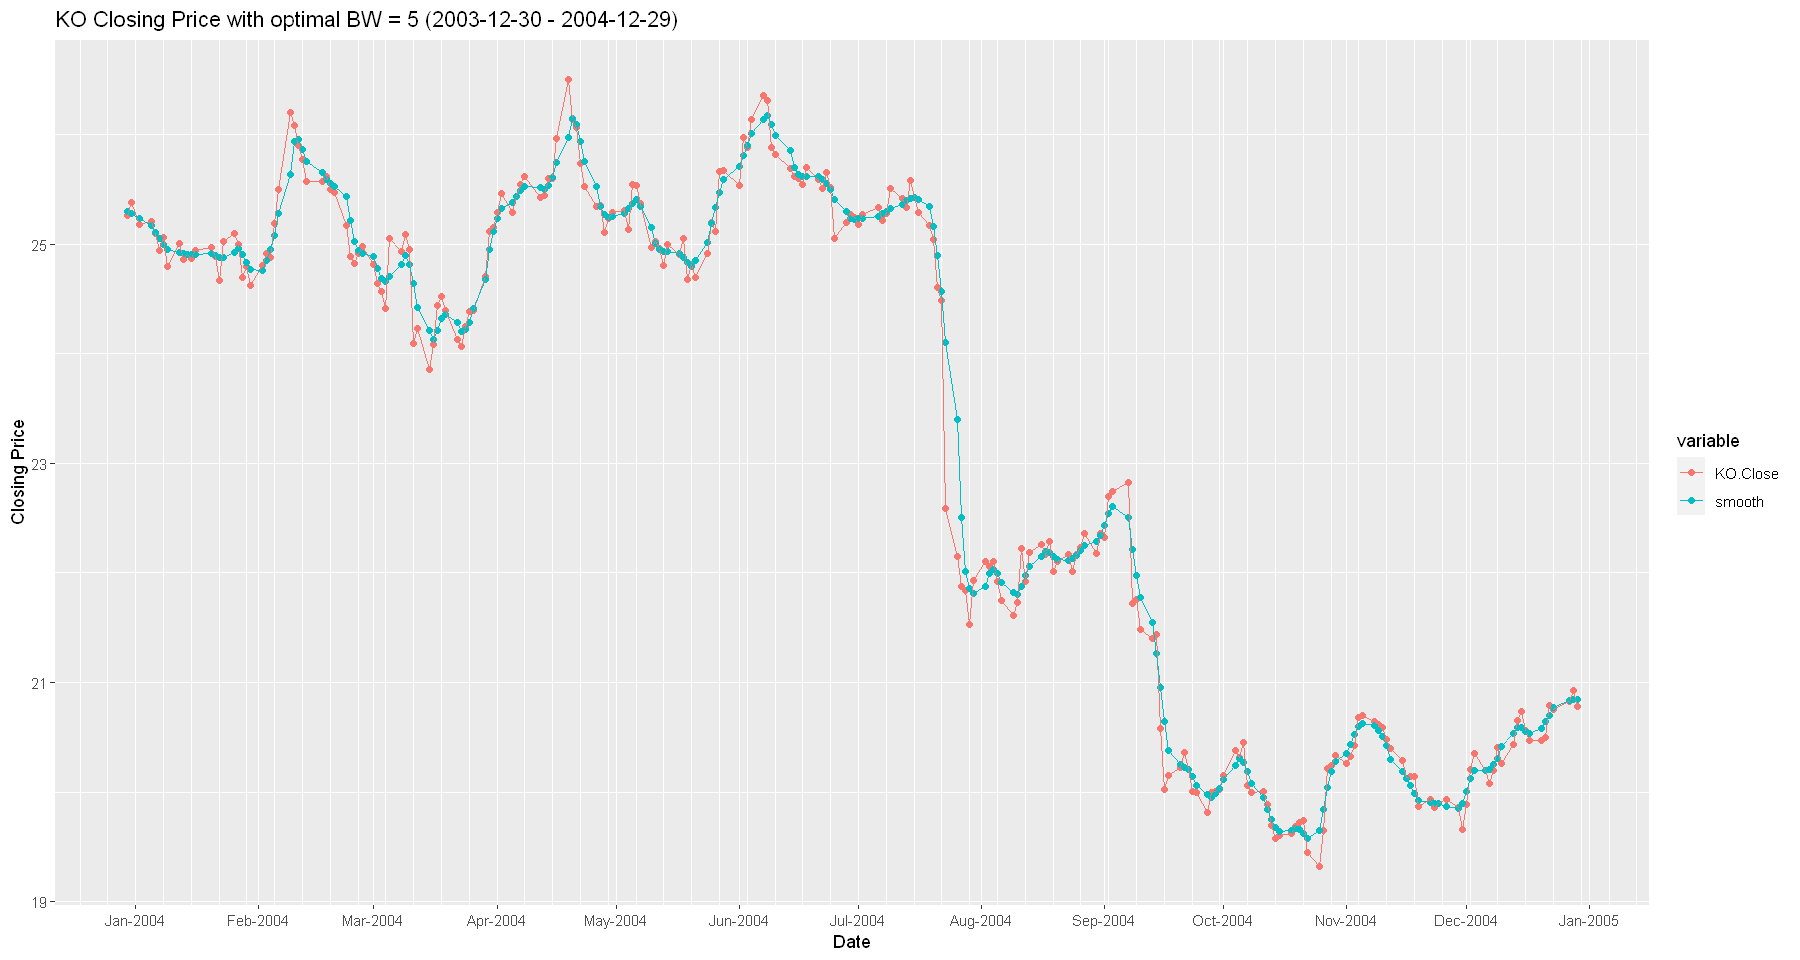

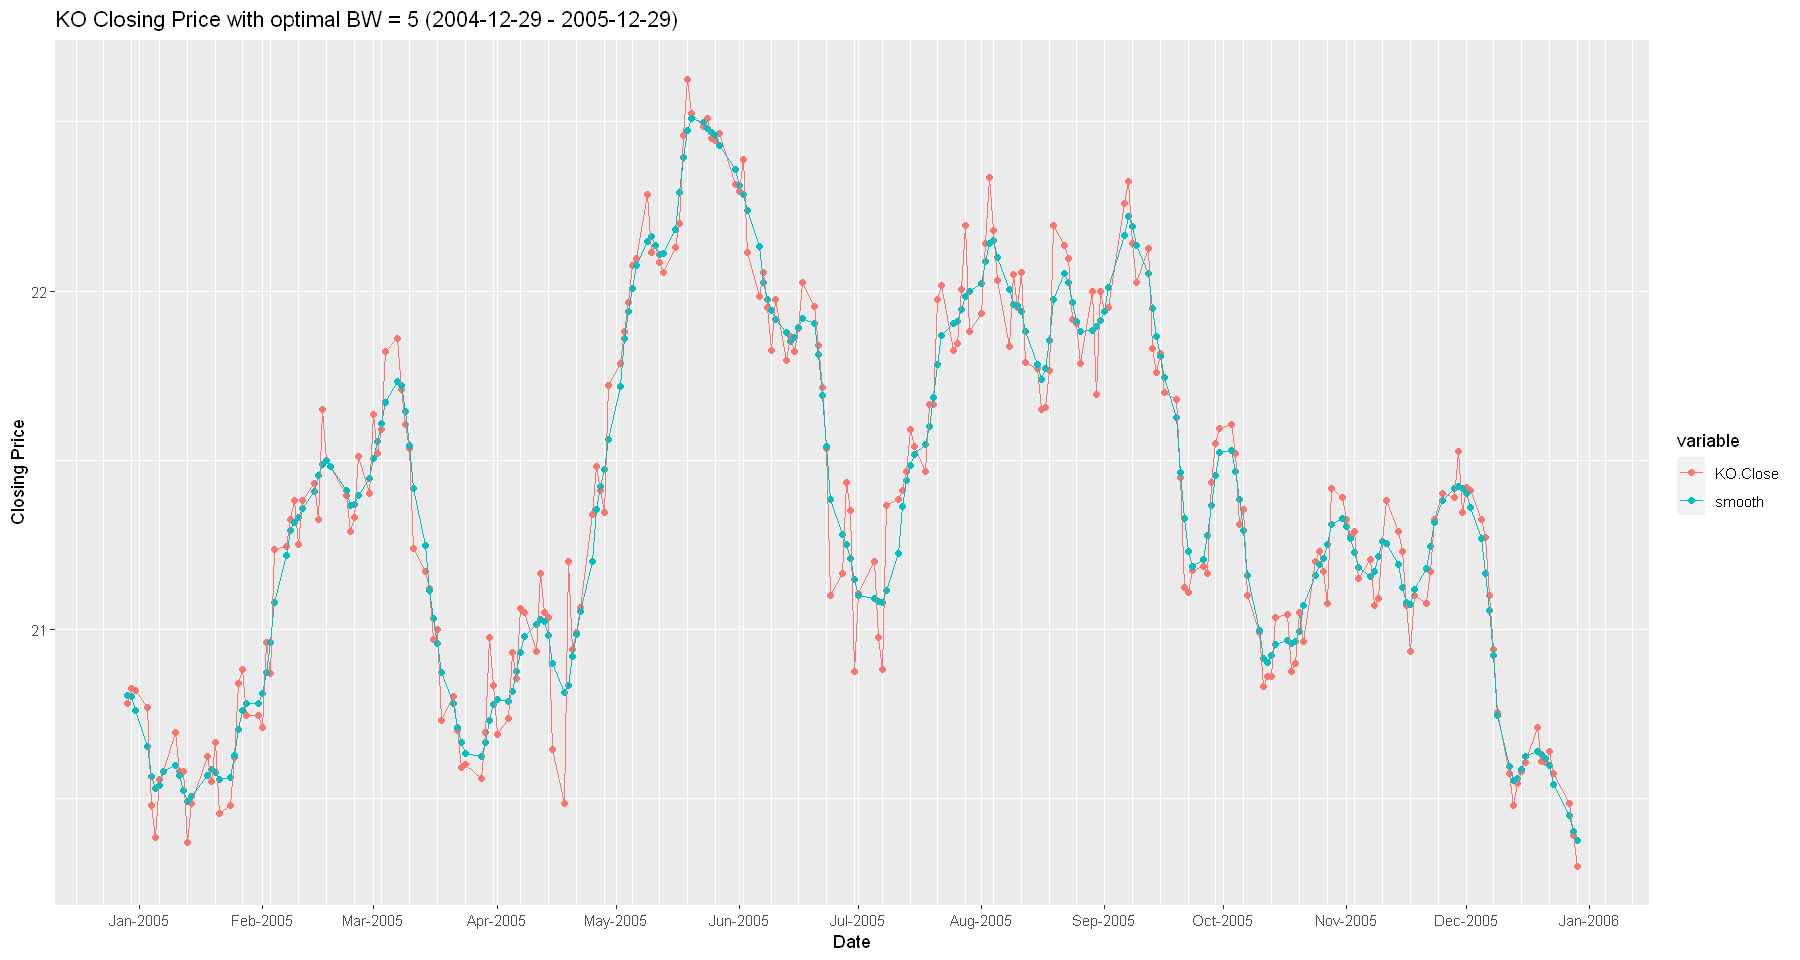

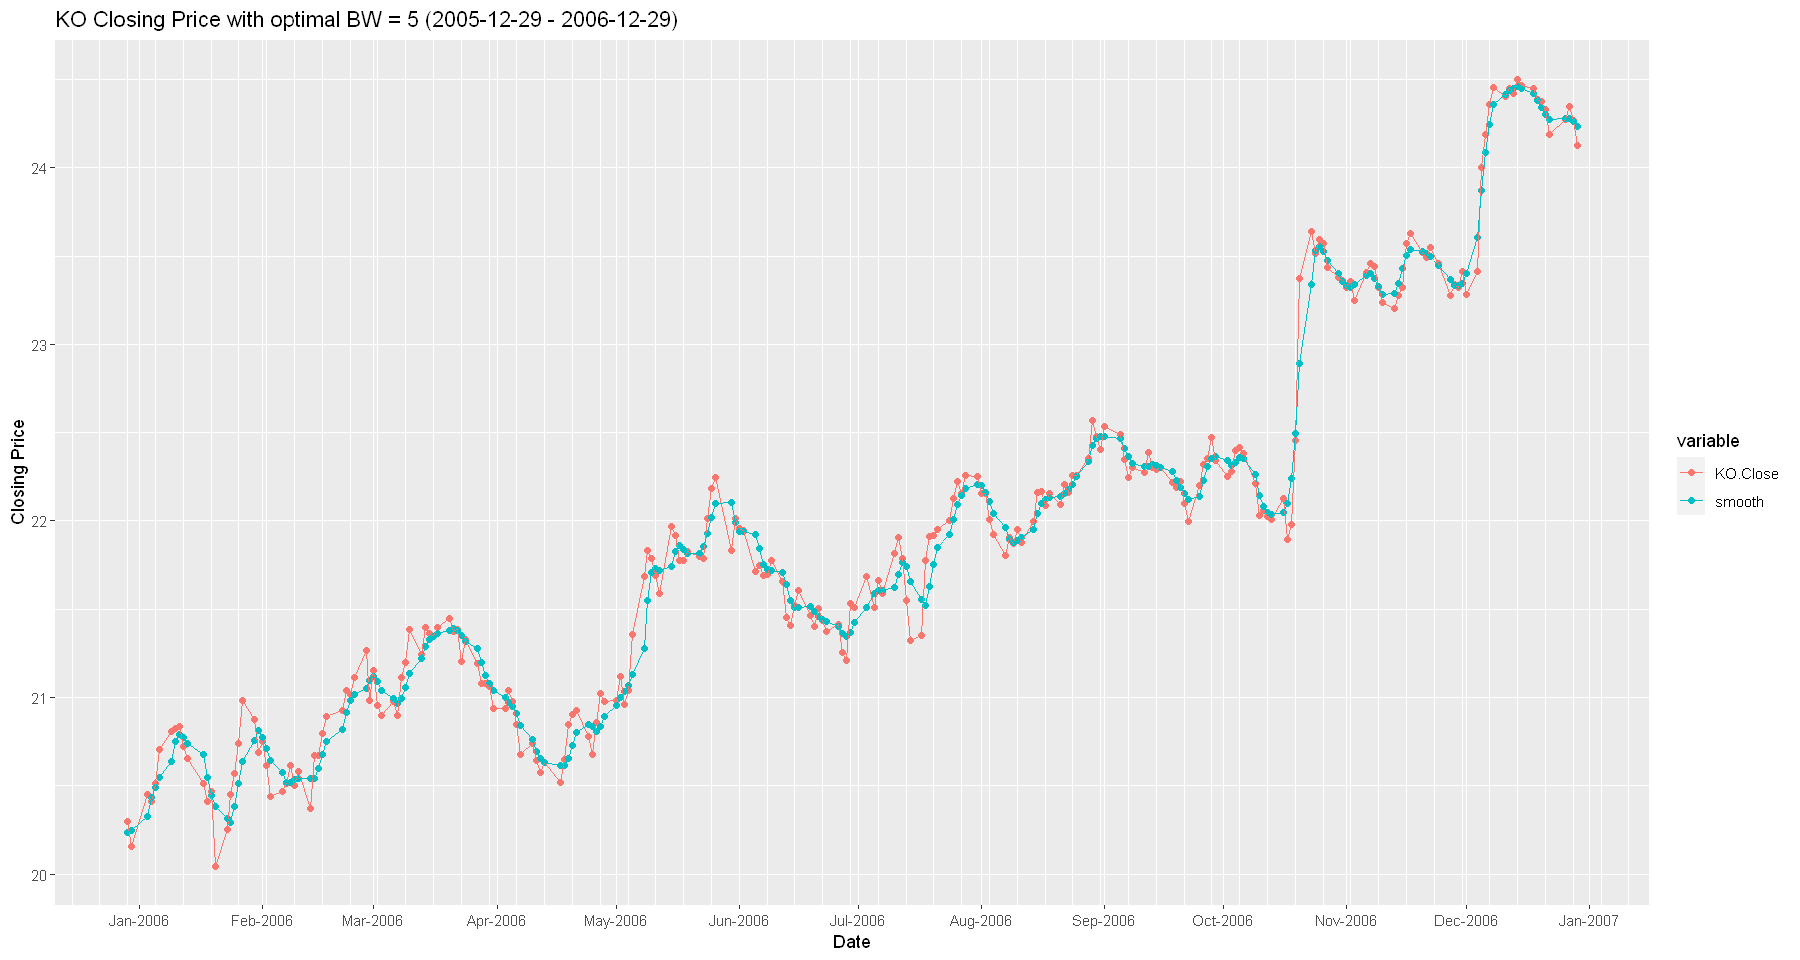

In [38]:
start_date <- "1995-01-01"
end_date <- "2006-01-01"
date_step <- 365
while (start_date < end_date)
{
    next_date <- as.Date(start_date) + date_step
    plot <- calc_and_plot_best_bw(KO_closing, start_date, next_date)
    print(plot)
    start_date <- next_date
}